In [1]:
# 0-1
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# ここから機械学習用ライブラリ
from sklearn.linear_model import LinearRegression, Ridge, Lasso # 重回帰、リッジ、ラッソ
from sklearn import tree                                        # 回帰木
from sklearn.ensemble import RandomForestRegressor              # ランダムフォレスト

# ユーティリティ
from sklearn.metrics import mean_squared_error, r2_score        # RMES, 決定係数
from sklearn.model_selection import train_test_split
from pprint import pprint
from collections import defaultdict
import warnings
warnings.simplefilter('ignore')

# 表示桁数の設定
%precision 3
pd.options.display.precision = 3

sns.set(style='white')
import japanize_matplotlib


In [2]:
# 0-2
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\datascientist_salary\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\datascientist_salary\\test.csv') 

# 「プチ」勉強会 20230701
* 今回は機械学習。丁度、新しい課題が始まったので、一通りsubmitまでやってみてEDA回りを中心に解説してみる。
* 機械学習は、応用などまだまだこれからだが、実践レベルで面白いのはやはりEDAだと思う。人が考えて適切なデータを用意することが水準をクリアするためには必要。<br>
* 機械学習は、代表的なライブラリであるscikit-learnのAPIが分かりやすくワンパターンなので「こんなもん？」とも感じるが、課題として考えると実は自由度が高くそこが難しいともいえる。<br>
* そしてEDAをベースに特徴量を弄るときに「Pythonのコーディングスキル」が必要になる。思いついたアイデアを形にするにはデータを自由に弄れるコーディングスキルが大事。<br>

## 今回取り組んでみたこと

1. 今回の目標。技術的なこととしては、ターゲットエンコーディングと可視化の引き出しを増やすこと。<br>
ターゲットエンコーディングは、単体のバリデーションではなくクロスバリデーションを覚えたい。（今日の資料では未着手）<br>

2. 今回もEDAはできるだけ丁寧に見ていきたい。<br>
```
    取り敢えずの結論からいうと、今回のデータは、質的変数の要素数がやたら多いのが特徴。
    質的変数では特徴量あたりの要素数が10個を超えると過学習リスクが高まるとされていて、ここをどうクリアするかが課題のひとつ。
```
* ほか、記号が多く意味が分かりにくいので国名はISOコードでちゃんと読み替えできるようにした。<br>
   その他の記号の意味もちゃんと調べた。
* また可視化に関しては、これまでhistplotばかりであまり使わなかった箱ひげ図を今回は沢山使ってみた。<br>
ほか、今回は回帰問題なので予測値との残差の可視化も行った。

3. 途中、予測に反映されていない特徴量もいろいろ試している。作りこむとバリデーションスコアは上がるが最終スコアに反映されにくいのは、やはり過学習だとわかる。<br>
(取り敢えず、いろいろ作ったものも特徴量削除で消してある)<br>
バリデーションでは4万台前半まで出るが、提出データでは未だ5万を切れていない。最初はターゲットエンコーディングのメモリリークかと思ったがそうではないっぽい。

## データサイエンティスト関連職種の職員の給料を予測しよう

## データ概観

はじめはグー。定型のコードを貼り付けて実行して確認していく。<br>
ちなみに、display()でDataFrameをいくつもout欄に並べられるので、使うのが吉。<br>
特に確認が必要なのは、
```
訓練データとテストデータ双方の欠損値があるcolumnsと数
全体のデータ数、各columnsのDtype、
目的変数の最大、最小、平均、標準偏差
質的変数のuniqueの数
```
今回、job_titleが91もある点が目を引く。あと、入社年とされたwork_yearが4つしかない。（これは後で訂正してもらった）

In [3]:
# 1-0
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))

# 欠損値                     ： train   test
# emplyment_type             :   12       5
# remote_ratio               : 1518     405

# データ数が3004とあまり多くない
# カテゴリ変数の要素数が多い(一般に10個未満が望ましい)ので過学習リスクが大きい印象
# 関係性に注意しながらカテゴリ要素を集約したり、要素数が少ないカテゴリとの合成を考慮する


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               3004 non-null   int64  
 1   work_year           3004 non-null   int64  
 2   experience_level    3004 non-null   object 
 3   employment_type     2992 non-null   object 
 4   job_title           3004 non-null   object 
 5   employee_residence  3004 non-null   object 
 6   remote_ratio        1486 non-null   float64
 7   company_location    3004 non-null   object 
 8   company_size        3004 non-null   object 
 9   salary              3004 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.8+ KB


None

,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary
0,1282,2023,SE,FT,Data Science Lead,US,NaN,US,M,225900
1,220,2023,SE,FT,Data Analyst,US,NaN,US,M,140000
2,3568,2021,SE,FT,Data Engineer,US,100.0,US,M,150000
3,129,2023,MI,FT,Data Analytics Manager,US,NaN,US,M,155000
4,1216,2023,SE,FT,Data Engineer,US,100.0,US,M,160000


,index,work_year,remote_ratio,salary
count,3004.000,3004.000,1486.000,3004.000
mean,1879.024,2022.377,95.054,137750.422
std,1080.940,0.686,14.933,62594.504
min,0.000,2020.000,50.000,5132.000
25%,942.750,2022.000,100.000,95000.000
50%,1870.500,2022.000,100.000,135000.000
75%,2813.250,2023.000,100.000,175152.000
max,3754.000,2023.000,100.000,430967.000


,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,3004,2992,3004,3004,3004,3004
unique,4,3,91,71,67,3
top,SE,FT,Data Engineer,US,US,M
freq,2028,2976,844,2409,2438,2526


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               751 non-null    int64  
 1   work_year           751 non-null    int64  
 2   experience_level    751 non-null    object 
 3   employment_type     746 non-null    object 
 4   job_title           751 non-null    object 
 5   employee_residence  751 non-null    object 
 6   remote_ratio        346 non-null    float64
 7   company_location    751 non-null    object 
 8   company_size        751 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 52.9+ KB


None

,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,2494,2022,SE,FT,Data Scientist,US,NaN,US,M
1,2534,2022,SE,FT,Data Engineer,US,NaN,US,M
2,380,2023,SE,FT,Data Engineer,US,NaN,US,M
3,2472,2022,EN,FT,Data Scientist,FR,50.0,FR,L
4,1876,2022,EN,FT,Data Engineer,US,NaN,US,M


,index,work_year,remote_ratio
count,751.000,751.000,346.000
mean,1868.904,2022.361,93.931
std,1097.436,0.715,16.352
min,6.000,2020.000,50.000
25%,904.000,2022.000,100.000
50%,1893.000,2022.000,100.000
75%,2823.000,2023.000,100.000
max,3750.000,2023.000,100.000


,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,751,746,751,751,751,751
unique,4,2,56,41,38,3
top,SE,FT,Data Engineer,US,US,M
freq,488,742,196,595,602,627


## EDA（データ探索）

```Dataset.columns
salary             : 給料(＄)
index              : 職員の固有番号
work_year          : 勤務年
experience_level   : 経験レベル
employment_type    : 雇用の種類
job_title          : 職種
employee_residence : 職員の住居
remote_ratio       : リモートワーク率(%)
campany_location   : 会社の所在
campany_size       : 会社の規模
```

,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary
0,1282,2023,SE,FT,Data Science Lead,US,NaN,US,M,225900
1,220,2023,SE,FT,Data Analyst,US,NaN,US,M,140000
2,3568,2021,SE,FT,Data Engineer,US,100.0,US,M,150000
3,129,2023,MI,FT,Data Analytics Manager,US,NaN,US,M,155000
4,1216,2023,SE,FT,Data Engineer,US,100.0,US,M,160000
...,...,...,...,...,...,...,...,...,...,...
2999,203,2023,EX,FT,Data Engineer,US,NaN,US,M,220000
3000,1129,2023,SE,FT,Machine Learning Engineer,US,100.0,US,M,200000
3001,2453,2022,SE,FT,Data Engineer,US,NaN,US,M,130000
3002,3650,2021,SE,FT,Machine Learning Engineer,IN,100.0,IN,L,24342


<Axes: xlabel='salary'>

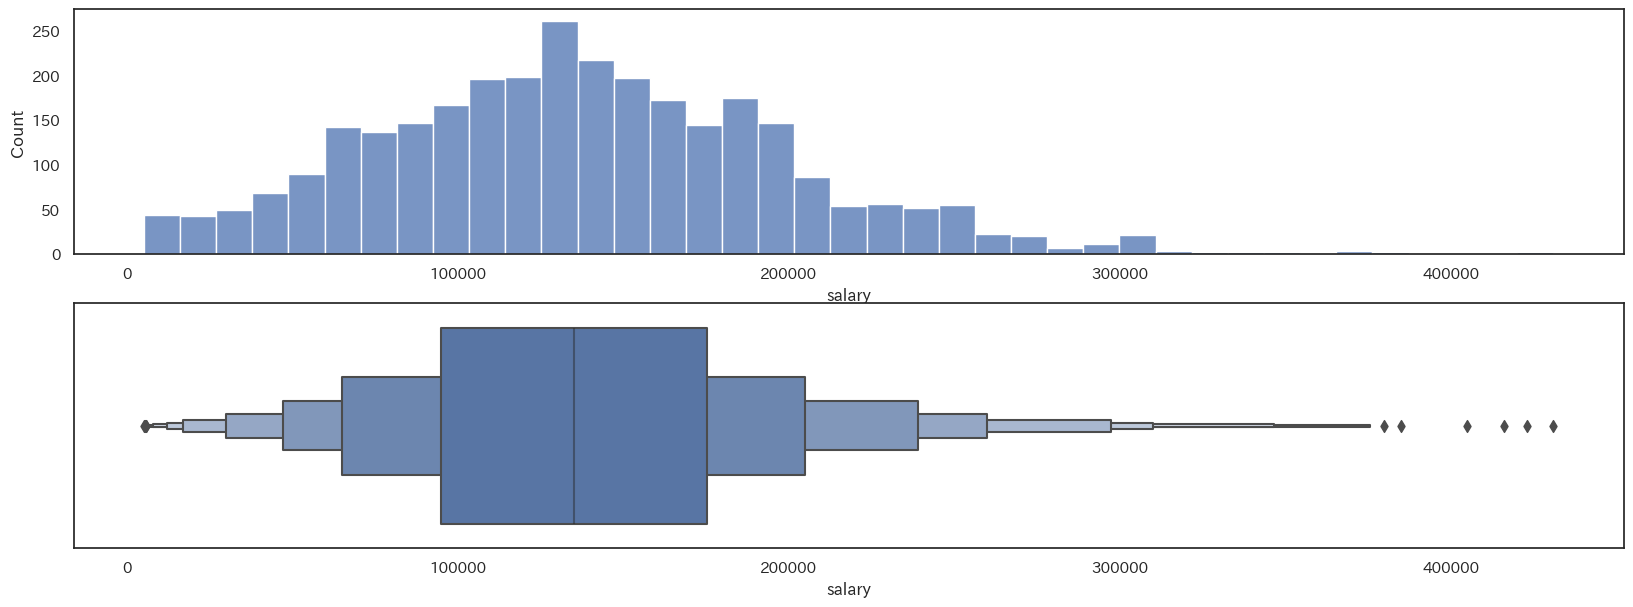

In [4]:
#1-1 salary

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
display(df)
sns.histplot(df.salary, ax=ax1)
sns.boxenplot(x=df.salary, ax=ax2)

# 一部のハイサラリー者を除いて、ほぼほぼ正規分布っぽい形になっている
# 給与は通常正規分布しない（低処遇層に寄っている）が、統計の取り方の影響と思う
# 外れ値の処理が必要かもしれない

0.5292605942956908 0.6449053067662294 0.8936986496963446


<Axes: xlabel='work_year', ylabel='salary'>

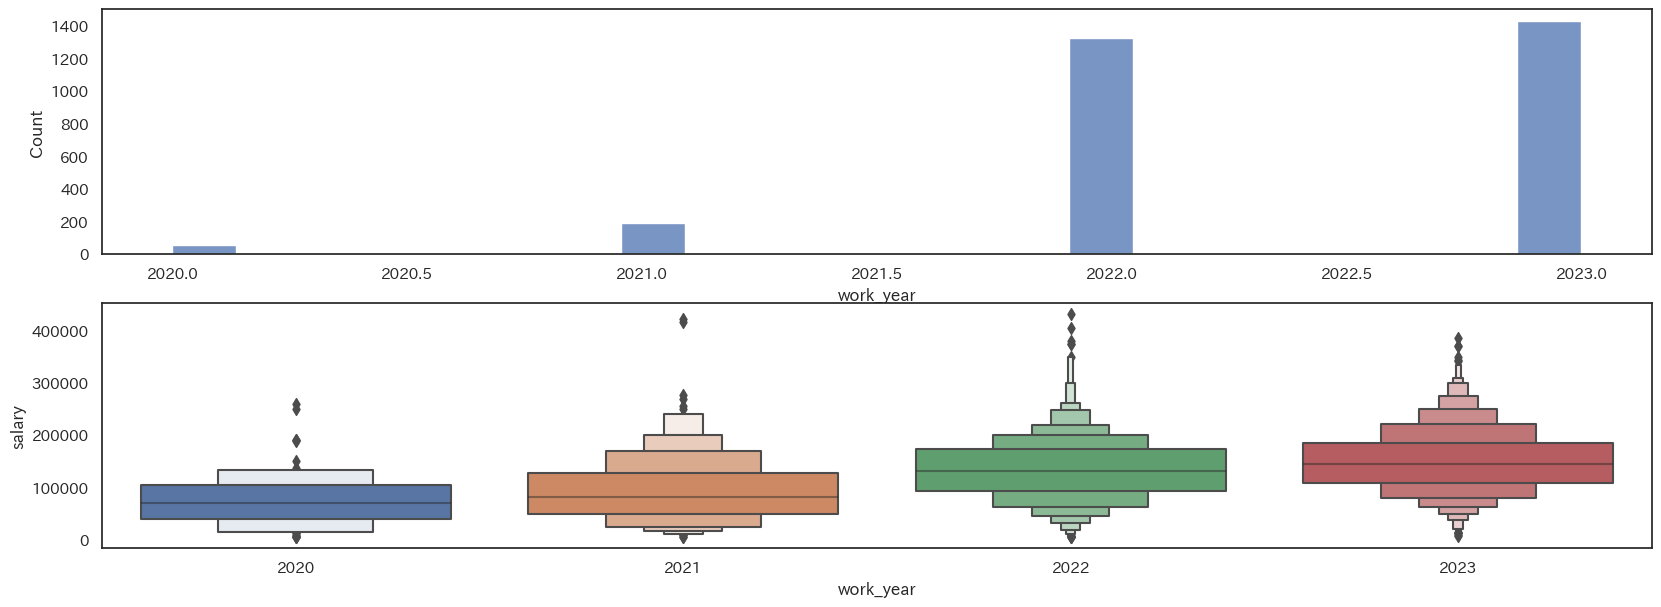

In [5]:
# 1-2 work_year

y2020 = df[df['work_year']==2020]['salary'].mean()
y2021 = df[df['work_year']==2021]['salary'].mean()
y2022 = df[df['work_year']==2022]['salary'].mean()
y2023 = df[df['work_year']==2023]['salary'].mean()
print(y2020 / y2023, y2021 / y2023, y2022 / y2023)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(df.work_year, ax=ax1)
sns.boxenplot(df, x='work_year', y='salary', ax=ax2)

# 入社した年ではなくデータの採取年を意味していると思われる
# 最近になるほどベースが上がっており比率も大きい（2023年は2020年のほぼ2倍）
# 年が変われば別の職種と見る必要があるかもしれない ⇒ 今後要対応

salary          
                  count    median
experience_level                 
EX                   87  200000.0
SE                 2028  147100.0
MI                  647  100000.0
EN                  242   70000.0

,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary
2252,2011,2022,MI,FT,Data Analyst,GB,NaN,GB,M,430967
2591,3747,2021,MI,FT,Applied Machine Learning Scientist,US,50.0,US,L,423000


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary
2911,83,2022,EN,FT,AI Developer,IN,50.0,IN,L,300000


<Axes: xlabel='experience_level', ylabel='salary'>

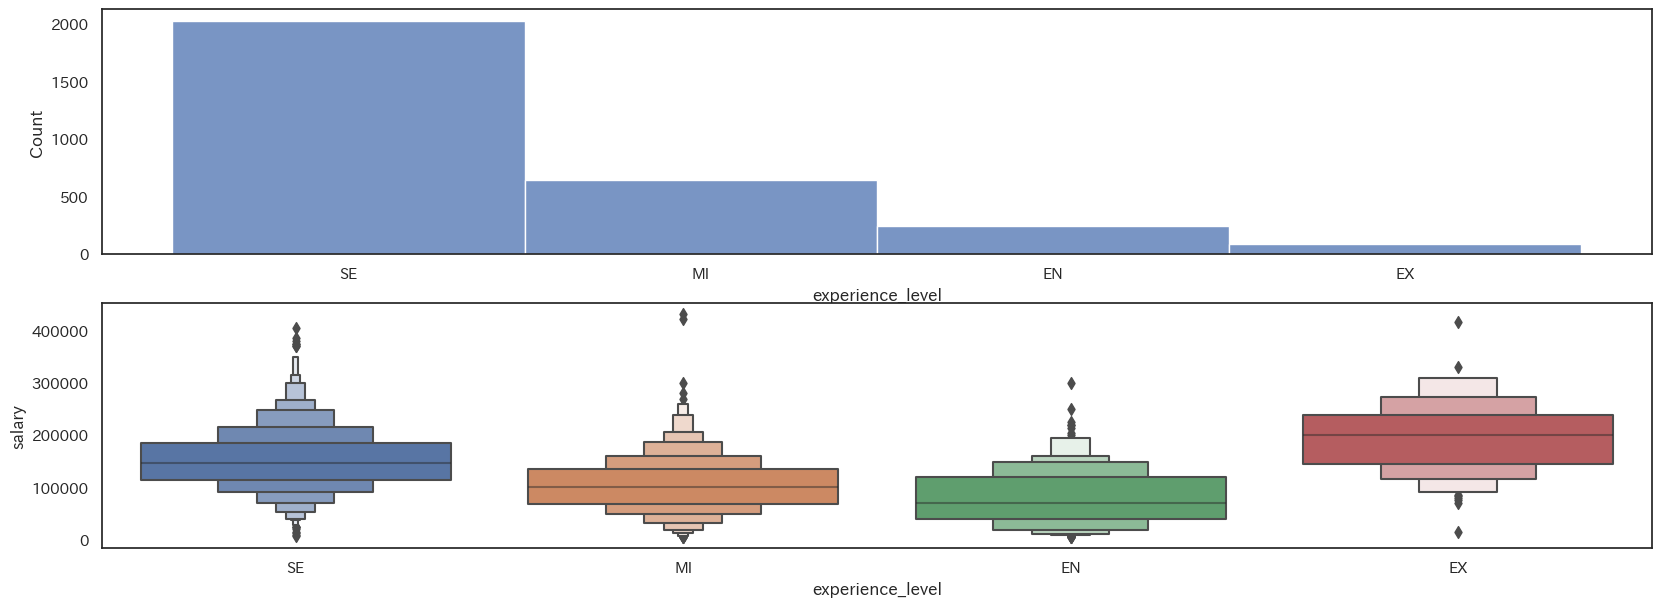

In [6]:
#1-3 experience_level

df_ = df.groupby(['experience_level'])[['salary']].agg(['count', 'median']).sort_values(('salary', 'median'), ascending=False)
display(df_)
display(df[(df['experience_level']=='MI') & (df['salary'] >= 400000)])
display(df[(df['experience_level']=='EN') & (df['salary'] >= 300000)])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(df.experience_level, ax=ax1)
sns.boxenplot(df, x='experience_level', y='salary', ax=ax2)

# EN: Entry Level（初級）, MI: Mid-Level（中級レベル）, SE: Senior/Subject Matter Expert（上級レベル）, EX: Experienced（経験豊富）
# MIに2名、job_titleからみても外れ値がいる
# ENの１名もjob_titleからみて外れ値
# SEレベルが全体の68%と多いことがsalaryの分布が正規分布に近いことの原因とみられる

salary            
                 count        mean
employment_type                   
FT                2976  138381.500
CT                  10  113446.900
FL                   6   61259.167

,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary
174,3537,2021,MI,NaN,3D Computer Vision Researcher,IN,50.0,IN,M,5409
619,3481,2022,EN,NaN,Data Scientist,DZ,50.0,DZ,M,100000
677,971,2022,EN,NaN,Data Analyst,US,100.0,US,S,34320
794,3710,2020,EN,NaN,Data Scientist,IT,50.0,IT,S,21669
1015,3735,2021,EN,NaN,AI Scientist,BR,100.0,US,S,12000
1420,3496,2021,EN,NaN,Data Analyst,ES,50.0,ES,M,10354
1465,3576,2020,EN,NaN,ML Engineer,DE,100.0,DE,S,15966
1681,2501,2022,EN,NaN,Data Analyst,CN,50.0,US,S,125404
1836,1165,2023,EN,NaN,Data Analyst,PL,100.0,IN,L,17779
1972,2378,2022,EN,NaN,BI Analyst,MX,100.0,US,L,12000


<Axes: xlabel='employment_type', ylabel='salary'>

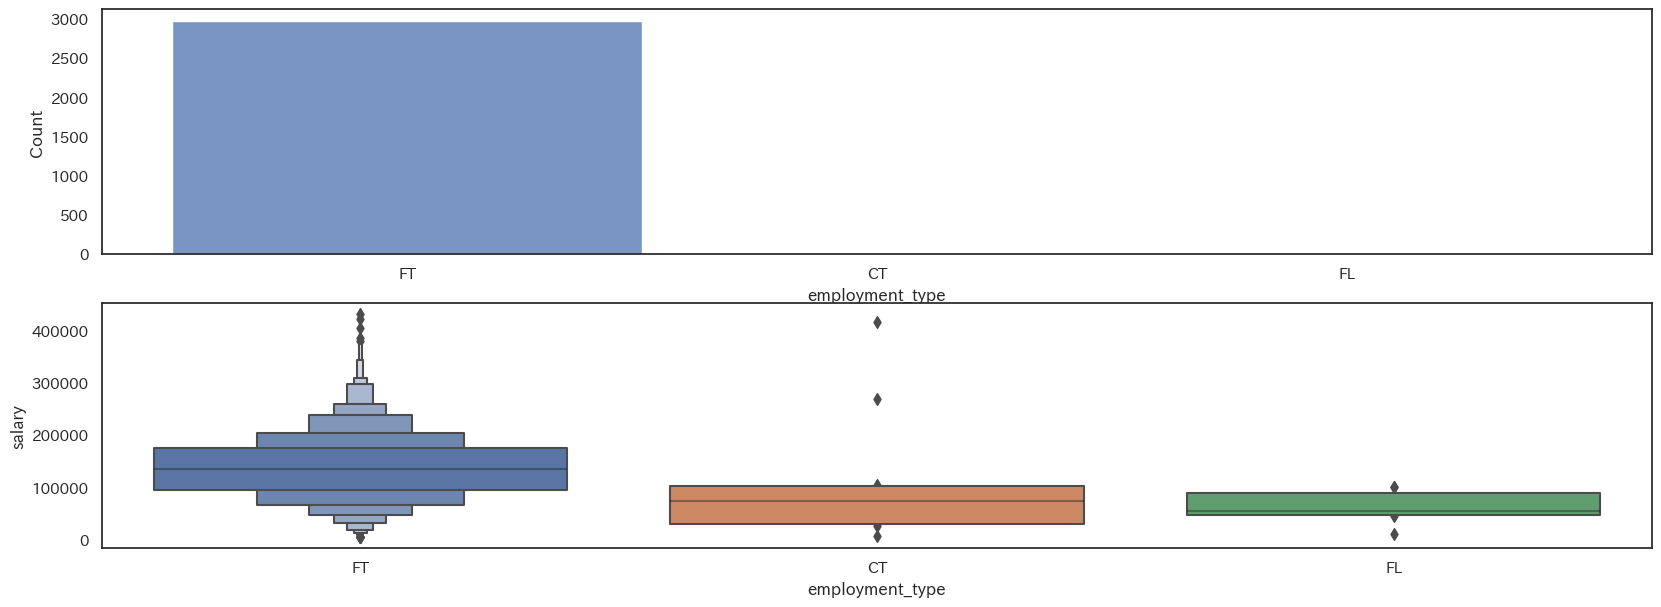

In [7]:
#1-4 employment_type

df_ = df.groupby(['employment_type'])[['salary']].agg(['count', 'mean']).sort_values(('salary', 'mean'), ascending=False)
display(df_)

display(df[df['employment_type'].isnull()])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(df.employment_type, ax=ax1)
sns.boxenplot(df, x='employment_type', y='salary', ax=ax2)

# FT: Full-Time（正規社員）, CT: Contact（契約社員）,  FL:Freelance（フリーランス）
# ほとんどFT。CTに一部高給取りがいるが、ほかは一時雇の低給与
# 欠損値の12名は1人を除いて全員ENの低給与層であり、FLに入れても問題ないと思われる。


91


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job
0,1282,2023,SE,FT,Data Science Lead,US,NaN,US,M,225900,Lead,Lead
1,220,2023,SE,FT,Data Analyst,US,NaN,US,M,140000,Non_title,Analyst
2,3568,2021,SE,FT,Data Engineer,US,100.0,US,M,150000,Non_title,Engineer
3,129,2023,MI,FT,Data Analytics Manager,US,NaN,US,M,155000,Manager,Manager
4,1216,2023,SE,FT,Data Engineer,US,100.0,US,M,160000,Non_title,Engineer
...,...,...,...,...,...,...,...,...,...,...,...,...
2999,203,2023,EX,FT,Data Engineer,US,NaN,US,M,220000,Non_title,Engineer
3000,1129,2023,SE,FT,Machine Learning Engineer,US,100.0,US,M,200000,Non_title,Engineer
3001,2453,2022,SE,FT,Data Engineer,US,NaN,US,M,130000,Non_title,Engineer
3002,3650,2021,SE,FT,Machine Learning Engineer,IN,100.0,IN,L,24342,Non_title,Engineer


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,position,job
0,2494,2022,SE,FT,Data Scientist,US,NaN,US,M,Non_title,Scientist
1,2534,2022,SE,FT,Data Engineer,US,NaN,US,M,Non_title,Engineer
2,380,2023,SE,FT,Data Engineer,US,NaN,US,M,Non_title,Engineer
3,2472,2022,EN,FT,Data Scientist,FR,50.0,FR,L,Non_title,Scientist
4,1876,2022,EN,FT,Data Engineer,US,NaN,US,M,Non_title,Engineer
...,...,...,...,...,...,...,...,...,...,...,...
746,1125,2023,MI,FT,Data Infrastructure Engineer,US,NaN,US,M,Non_title,Engineer
747,150,2023,SE,FT,Data Scientist,US,NaN,US,M,Non_title,Scientist
748,3024,2022,SE,FT,Data Scientist,US,NaN,US,M,Non_title,Scientist
749,2775,2022,SE,FT,ML Engineer,US,100.0,US,M,Non_title,Engineer


{'Compliance Data Analyst', 'Cloud Data Architect'}


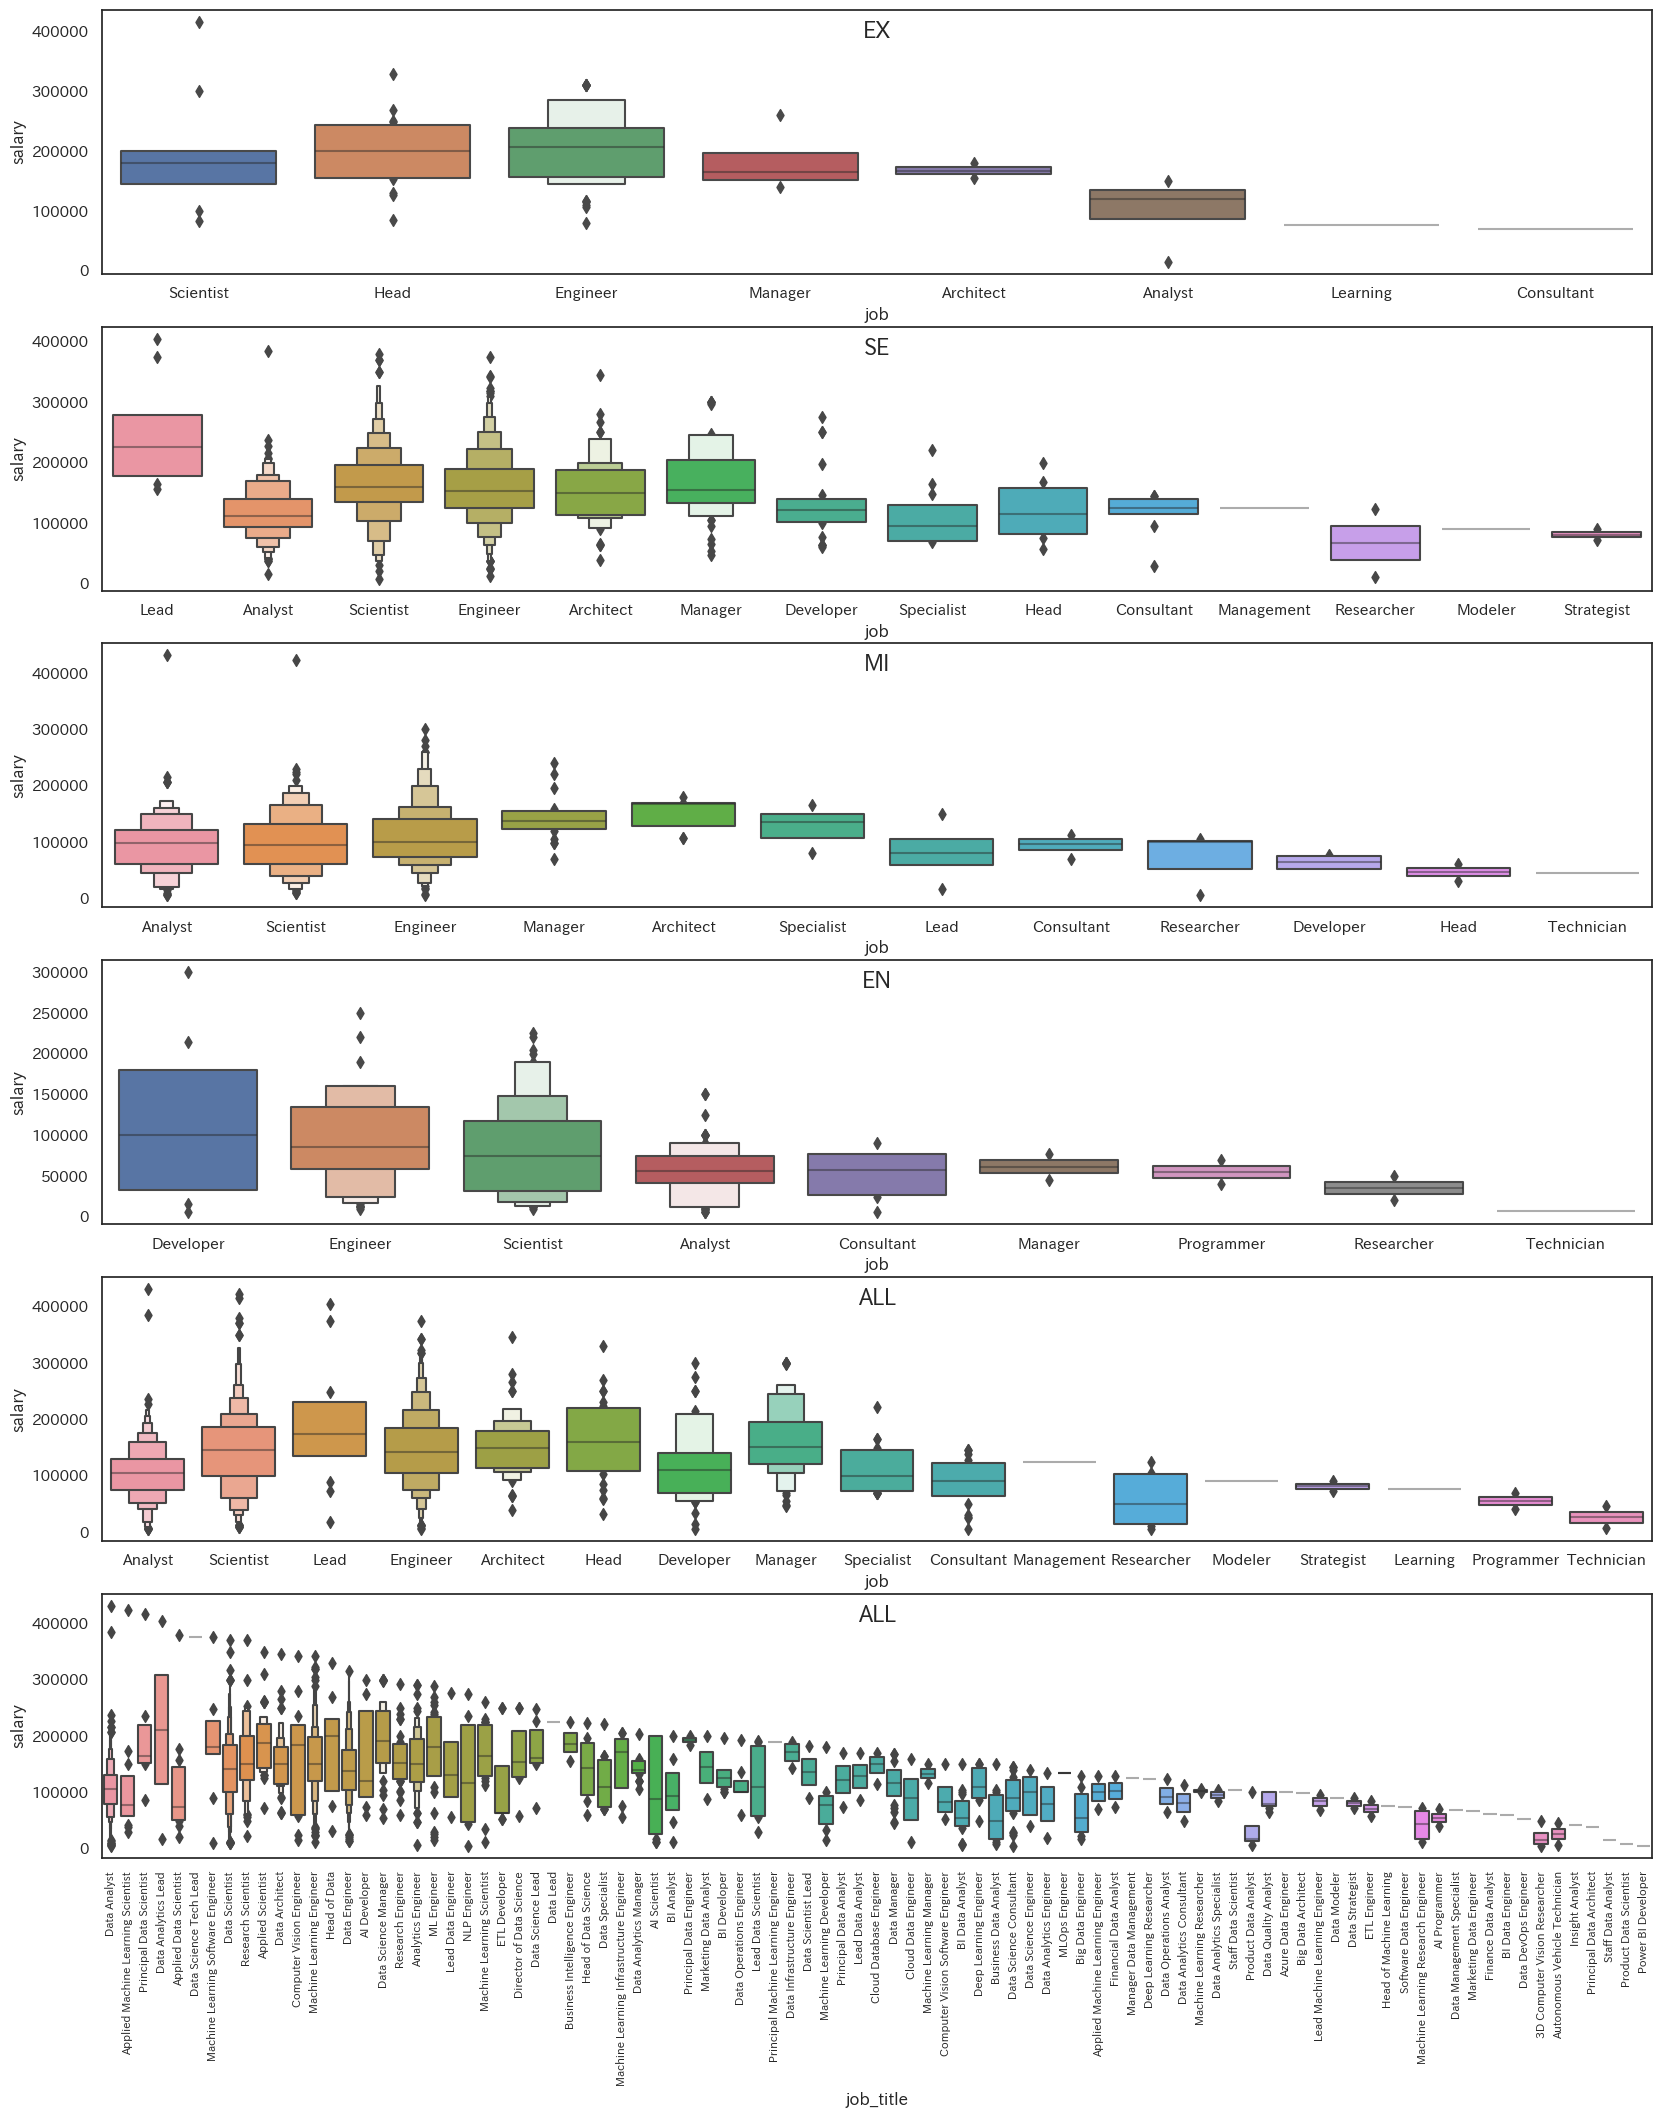

In [8]:
#1-5 job_title

print(len(set(df['job_title'])))

for i, j in enumerate(df['job_title']):
    if j.split()[0] == 'Head':
        df.at[i, 'position'] = 'Head'
        df.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Director':
        df.at[i, 'position'] = 'Director'
        df.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Principal':
        df.at[i, 'position'] = 'Principal'
        df.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[-1] in ['Lead', 'Manager', 'Management']:
        df.at[i, 'position'] = j.split()[-1]
        df.at[i, 'job'] = j.split()[-1]
    else:
        df.at[i, 'position'] = 'Non_title'
        df.at[i, 'job'] = j.split()[-1]

for i, j in enumerate(df_test['job_title']):
    if j.split()[0] == 'Head':
        df_test.at[i, 'position'] = 'Head'
        df_test.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Director':
        df_test.at[i, 'position'] = 'Director'
        df_test.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Principal':
        df_test.at[i, 'position'] = 'Principal'
        df_test.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[-1] in ['Lead', 'Manager', 'Management']:
        df_test.at[i, 'position'] = j.split()[-1]
        df_test.at[i, 'job'] = j.split()[-1]
    else:
        df_test.at[i, 'position'] = 'Non_title'
        df_test.at[i, 'job'] = j.split()[-1]
display(df)
display(df_test)

print(set(df_test['job_title']) - set(df['job_title']))

df01 = df.sort_values('salary', ascending=False)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(20, 24))
sns.boxenplot(df01[df01['experience_level']=='EX'], x='job', y='salary', ax=ax1)
ax1.set_title('EX',fontsize=16, pad=-20)
sns.boxenplot(df01[df01['experience_level']=='SE'], x='job', y='salary', ax=ax2)
ax2.set_title('SE',fontsize=16, pad=-20)
sns.boxenplot(df01[df01['experience_level']=='MI'], x='job', y='salary', ax=ax3)
ax3.set_title('MI',fontsize=16, pad=-20)
sns.boxenplot(df01[df01['experience_level']=='EN'], x='job', y='salary', ax=ax4)
ax4.set_title('EN',fontsize=16, pad=-20)
sns.boxenplot(df01, x='job', y='salary', ax=ax5)
ax5.set_title('ALL',fontsize=16, pad=-20)
sns.boxenplot(df01, x='job_title', y='salary', ax=ax6)
ax6.set_title('ALL',fontsize=16, pad=-20)
ax6.tick_params(axis='x', rotation=90, labelsize=8)

# job_titleが91もあるので整理が必要（そのままだと過学習してしまう）
# 管理職：接尾語：Lead, Manager, Management, 接頭語：Director, Head, Principal
# 職種：Analyst, Architect, Consultant, Developer, Engineer, Modeler, Programmer, Researcher, Scientist, Specialist, Strategist, Technician
# そのままone-hotエンコーディングしてしまうのではなく、カテゴリ毎に分けてターゲットエンコーディングする
# なお、df_testにのみ存在するjob_titleが2つある。'Compliance Data Analyst', 'Cloud Data Architect'


In [9]:
#ISO3166-1国名コード（alpha2）

c_code_text = '''
IS	アイスランド
IE	アイルランド
AZ	アゼルバイジャン
AF	アフガニスタン
US	アメリカ合衆国
VI	アメリカ領ヴァージン諸島
AS	アメリカ領サモア
AE	アラブ首長国連邦
DZ	アルジェリア
AR	アルゼンチン
AW	アルバ
AL	アルバニア
AM	アルメニア
AI	アンギラ
AO	アンゴラ
AG	アンティグア・バーブーダ
AD	アンドラ
YE	イエメン
GB	イギリス
IO	イギリス領インド洋地域
VG	イギリス領ヴァージン諸島
IL	イスラエル
IT	イタリア
IQ	イラク
IR	イラン・イスラム共和国
IN	インド
ID	インドネシア
WF	ウォリス・フツナ
UG	ウガンダ
UA	ウクライナ
UZ	ウズベキスタン
UY	ウルグアイ
EC	エクアドル
EG	エジプト
EE	エストニア
ET	エチオピア
ER	エリトリア
SV	エルサルバドル
AU	オーストラリア
AT	オーストリア
AX	オーランド諸島
OM	オマーン
NL	オランダ
GH	ガーナ
CV	カーボベルデ
GG	ガーンジー
GY	ガイアナ
KZ	カザフスタン
QA	カタール
UM	合衆国領有小離島
CA	カナダ
GA	ガボン
CM	カメルーン
GM	ガンビア
KH	カンボジア
MP	北マリアナ諸島
GN	ギニア
GW	ギニアビサウ
CY	キプロス
CU	キューバ
CW	キュラソー
GR	ギリシャ
KI	キリバス
KG	キルギス
GT	グアテマラ
GP	グアドループ
GU	グアム
KW	クウェート
CK	クック諸島
GL	グリーンランド
CX	クリスマス島
GE	グルジア
GD	グレナダ
HR	クロアチア
KY	ケイマン諸島
KE	ケニア
CI	コートジボワール
CC	ココス（キーリング）諸島
CR	コスタリカ
KM	コモロ
CO	コロンビア
CG	コンゴ共和国
CD	コンゴ民主共和国
SA	サウジアラビア
GS	サウスジョージア・サウスサンドウィッチ諸島
WS	サモア
ST	サントメ・プリンシペ
BL	サン・バルテルミー
ZM	ザンビア
PM	サンピエール島・ミクロン島
SM	サンマリノ
MF	サン・マルタン（フランス領）
SL	シエラレオネ
DJ	ジブチ
GI	ジブラルタル
JE	ジャージー
JM	ジャマイカ
SY	シリア・アラブ共和国
SG	シンガポール
SX	シント・マールテン（オランダ領）
ZW	ジンバブエ
CH	スイス
SE	スウェーデン
SD	スーダン
SJ	スヴァールバル諸島およびヤンマイエン島
ES	スペイン
SR	スリナム
LK	スリランカ
SK	スロバキア
SI	スロベニア
SZ	スワジランド
SC	セーシェル
GQ	赤道ギニア
SN	セネガル
RS	セルビア
KN	セントクリストファー・ネイビス
VC	セントビンセントおよびグレナディーン諸島
SH	セントヘレナ・アセンションおよびトリスタンダクーニャ
LC	セントルシア
SO	ソマリア
SB	ソロモン諸島
TC	タークス・カイコス諸島
TH	タイ
KR	大韓民国
TW	台湾（台湾省/中華民国）
TJ	タジキスタン
TZ	タンザニア
CZ	チェコ
TD	チャド
CF	中央アフリカ共和国
CN	中華人民共和国
TN	チュニジア
KP	朝鮮民主主義人民共和国
CL	チリ
TV	ツバル
DK	デンマーク
DE	ドイツ
TG	トーゴ
TK	トケラウ
DO	ドミニカ共和国
DM	ドミニカ国
TT	トリニダード・トバゴ
TM	トルクメニスタン
TR	トルコ
TO	トンガ
NG	ナイジェリア
NR	ナウル
NA	ナミビア
AQ	南極
NU	ニウエ
NI	ニカラグア
NE	ニジェール
JP	日本
EH	西サハラ
NC	ニューカレドニア
NZ	ニュージーランド
NP	ネパール
NF	ノーフォーク島
NO	ノルウェー
HM	ハード島とマクドナルド諸島
BH	バーレーン
HT	ハイチ
PK	パキスタン
VA	バチカン市国
PA	パナマ
VU	バヌアツ
BS	バハマ
PG	パプアニューギニア
BM	バミューダ
PW	パラオ
PY	パラグアイ
BB	バルバドス
PS	パレスチナ
HU	ハンガリー
BD	バングラデシュ
TL	東ティモール
PN	ピトケアン
FJ	フィジー
PH	フィリピン
FI	フィンランド
BT	ブータン
BV	ブーベ島
PR	プエルトリコ
FO	フェロー諸島
FK	フォークランド（マルビナス）諸島
BR	ブラジル
FR	フランス
GF	フランス領ギアナ
PF	フランス領ポリネシア
TF	フランス領南方・南極地域
BG	ブルガリア
BF	ブルキナファソ
BN	ブルネイ・ダルサラーム
BI	ブルンジ
VN	ベトナム
BJ	ベナン
VE	ベネズエラ・ボリバル共和国
BY	ベラルーシ
BZ	ベリーズ
PE	ペルー
BE	ベルギー
PL	ポーランド
BA	ボスニア・ヘルツェゴビナ
BW	ボツワナ
BQ	ボネール、シント・ユースタティウスおよびサバ
BO	ボリビア多民族国
PT	ポルトガル
HK	香港
HN	ホンジュラス
MH	マーシャル諸島
MO	マカオ
MK	マケドニア共和国
MG	マダガスカル
YT	マヨット
MW	マラウイ
ML	マリ
MT	マルタ
MQ	マルティニーク
MY	マレーシア
IM	マン島
FM	ミクロネシア連邦
ZA	南アフリカ
SS	南スーダン
MM	ミャンマー
MX	メキシコ
MU	モーリシャス
MR	モーリタニア
MZ	モザンビーク
MC	モナコ
MV	モルディブ
MD	モルドバ共和国
MA	モロッコ
MN	モンゴル
ME	モンテネグロ
MS	モントセラト
JO	ヨルダン
LA	ラオス人民民主共和国
LV	ラトビア
LT	リトアニア
LY	リビア
LI	リヒテンシュタイン
LR	リベリア
RO	ルーマニア
LU	ルクセンブルク
RW	ルワンダ
LS	レソト
LB	レバノン
RE	レユニオン
RU	ロシア連邦
'''
ISO_code = c_code_text.split('\n')[1:-1]
CODE = slice(0, 2, None)
NAME = slice(3, None, None)
ISO_dict = {i[CODE]:i[NAME] for i in ISO_code}

71
0.801930758988016


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job
948,3011,2022,SE,FT,Data Engineer,PR,100.0,PR,M,135000,Non_title,Engineer
1428,3637,2021,SE,FT,Lead Data Engineer,PR,50.0,US,S,160000,Non_title,Engineer
2412,2763,2022,SE,FT,Machine Learning Engineer,PR,100.0,PR,M,135000,Non_title,Engineer
2451,3010,2022,SE,FT,Data Engineer,PR,100.0,PR,M,200000,Non_title,Engineer
2921,2762,2022,SE,FT,Machine Learning Engineer,PR,100.0,PR,M,200000,Non_title,Engineer


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job,country_name
0,1282,2023,SE,FT,Data Science Lead,US,NaN,US,M,225900,Lead,Lead,アメリカ合衆国
1,220,2023,SE,FT,Data Analyst,US,NaN,US,M,140000,Non_title,Analyst,アメリカ合衆国
2,3568,2021,SE,FT,Data Engineer,US,100.0,US,M,150000,Non_title,Engineer,アメリカ合衆国
3,129,2023,MI,FT,Data Analytics Manager,US,NaN,US,M,155000,Manager,Manager,アメリカ合衆国
4,1216,2023,SE,FT,Data Engineer,US,100.0,US,M,160000,Non_title,Engineer,アメリカ合衆国
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,203,2023,EX,FT,Data Engineer,US,NaN,US,M,220000,Non_title,Engineer,アメリカ合衆国
3000,1129,2023,SE,FT,Machine Learning Engineer,US,100.0,US,M,200000,Non_title,Engineer,アメリカ合衆国
3001,2453,2022,SE,FT,Data Engineer,US,NaN,US,M,130000,Non_title,Engineer,アメリカ合衆国
3002,3650,2021,SE,FT,Machine Learning Engineer,IN,100.0,IN,L,24342,Non_title,Engineer,インド


{'ID', 'UZ', 'NZ', 'MK', 'DK', 'EG', 'IL'}


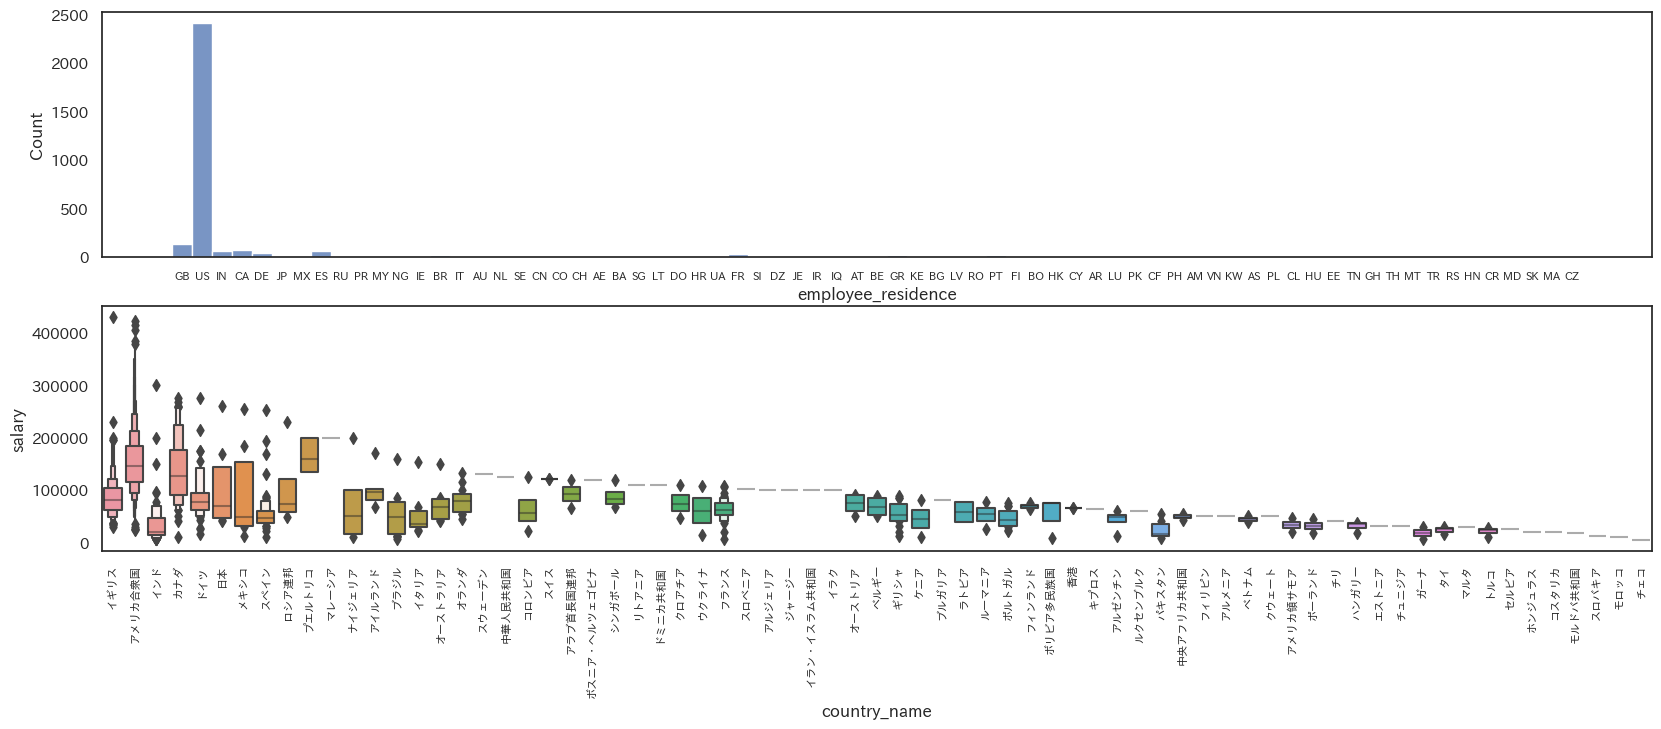

In [10]:
#1-6 employee_residence

print(len(set(df['employee_residence'])))
print(df[df['employee_residence']=='US']['employee_residence'].count() / df['employee_residence'].count())
display(df[df['employee_residence']=='PR'])

df['country_name'] = df['employee_residence'].apply(lambda x: ISO_dict[x])
display(df)
print(set(df_test['employee_residence'])-set(df['employee_residence']))

df01 = df.sort_values('salary', ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(x=df01['employee_residence'], ax=ax1)
sns.boxenplot(df01, x='country_name', y='salary', ax=ax2)

ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='x', rotation=90, labelsize=8)

# 従業員居住地（国）も71種類あるが、米国が8割を占めている。
# 国による傾向は、米国、カナダ、プエルトリコが高位でほかはちょぼちょぼなので、ざっくり纏める。
# なお、df_testにのみ存在するemployee_resicenceが7つある。'DK', 'NZ', 'ID', 'UZ', 'EG', 'IL', 'MK'


salary            
              count        mean
remote_ratio                   
0.0            1518  144708.565
100.0          1339  136251.811
50.0            147   79547.558

salary            
          count        mean
count     3.000       3.000
mean   1001.333  120169.311
std     745.268   35432.673
min     147.000   79547.558
25%     743.000  107899.684
50%    1339.000  136251.811
75%    1428.500  140480.188
max    1518.000  144708.565

<Axes: xlabel='remote_ratio', ylabel='salary'>

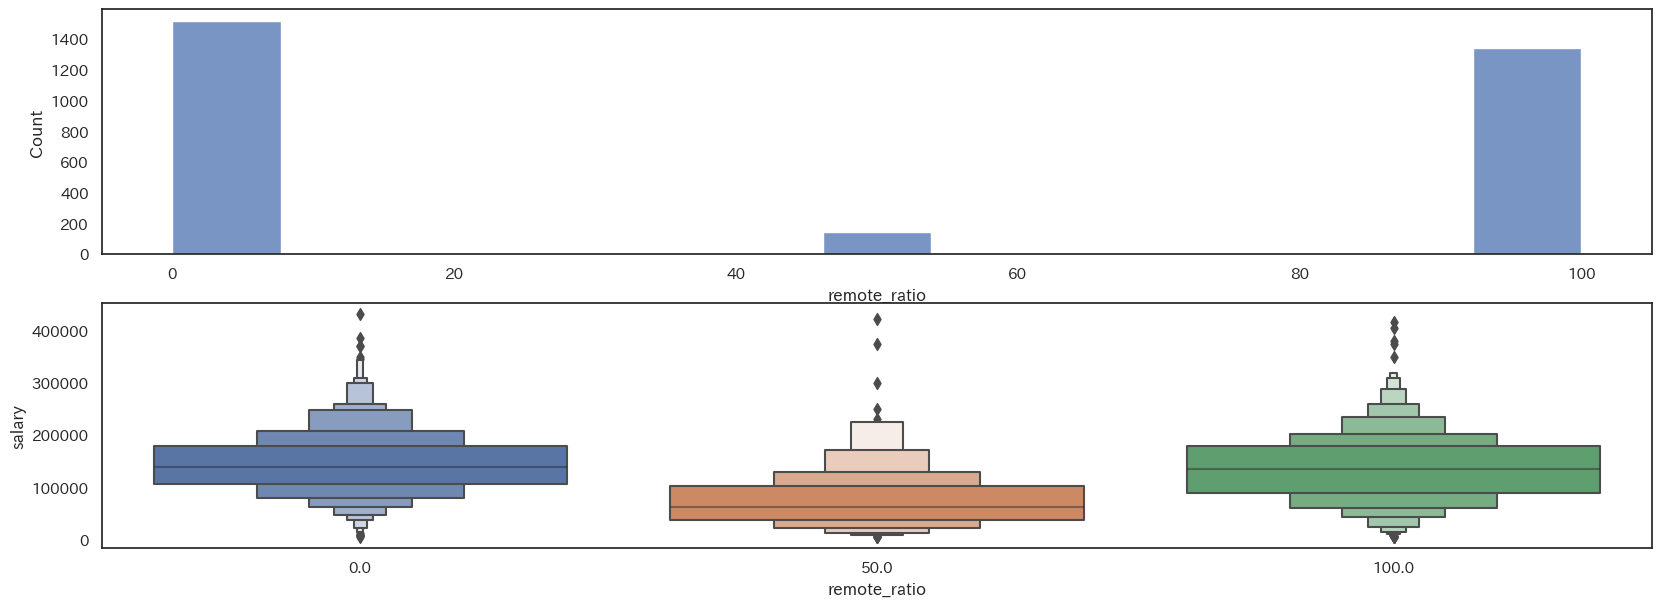

In [11]:
#1-7 remote_ratio

df['remote_ratio'] = df['remote_ratio'].fillna(0)
df_ = df.groupby(['remote_ratio'])[['salary']].agg(['count', 'mean']).sort_values(('salary', 'mean'), ascending=False)
display(df_)
display(df_.describe())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(df.remote_ratio, ax=ax1)
sns.boxenplot(x='remote_ratio',y='salary', data=df, ax=ax2)

# 欠損値を仮に0として比較すると中身は100%リモートと大差ない
# 50%リモート層は数も少ないが給与水準は全般に低め


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job,country_name,country_name2
0,1282,2023,SE,FT,Data Science Lead,US,0.0,US,M,225900,Lead,Lead,アメリカ合衆国,アメリカ合衆国
1,220,2023,SE,FT,Data Analyst,US,0.0,US,M,140000,Non_title,Analyst,アメリカ合衆国,アメリカ合衆国
2,3568,2021,SE,FT,Data Engineer,US,100.0,US,M,150000,Non_title,Engineer,アメリカ合衆国,アメリカ合衆国
3,129,2023,MI,FT,Data Analytics Manager,US,0.0,US,M,155000,Manager,Manager,アメリカ合衆国,アメリカ合衆国
4,1216,2023,SE,FT,Data Engineer,US,100.0,US,M,160000,Non_title,Engineer,アメリカ合衆国,アメリカ合衆国
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,203,2023,EX,FT,Data Engineer,US,0.0,US,M,220000,Non_title,Engineer,アメリカ合衆国,アメリカ合衆国
3000,1129,2023,SE,FT,Machine Learning Engineer,US,100.0,US,M,200000,Non_title,Engineer,アメリカ合衆国,アメリカ合衆国
3001,2453,2022,SE,FT,Data Engineer,US,0.0,US,M,130000,Non_title,Engineer,アメリカ合衆国,アメリカ合衆国
3002,3650,2021,SE,FT,Machine Learning Engineer,IN,100.0,IN,L,24342,Non_title,Engineer,インド,インド


{'ID', 'NZ', 'VN', 'MK', 'EG'}


,index,work_year,remote_ratio,salary
count,76.000,76.000,76.000,76.000
mean,2879.632,2021.553,84.211,69276.197
std,1000.005,0.823,28.531,49144.974
min,82.000,2020.000,0.000,6359.000
25%,2379.500,2021.000,50.000,37864.750
50%,3440.000,2022.000,100.000,58000.000
75%,3631.000,2022.000,100.000,84289.750
max,3746.000,2023.000,100.000,225000.000


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job,country_name,country_name2
242,3518,2021,EX,FT,Head of Data Science,RU,0.0,RU,M,85000,Head,Head,ロシア連邦,ロシア連邦
946,3721,2020,SE,FL,Computer Vision Engineer,RU,100.0,US,S,60000,Non_title,Engineer,ロシア連邦,アメリカ合衆国
1620,3519,2021,EX,FT,Head of Data,RU,50.0,RU,L,230000,Head,Head,ロシア連邦,ロシア連邦
2227,3472,2022,MI,FT,Data Scientist,RU,100.0,US,S,48000,Non_title,Scientist,ロシア連邦,アメリカ合衆国


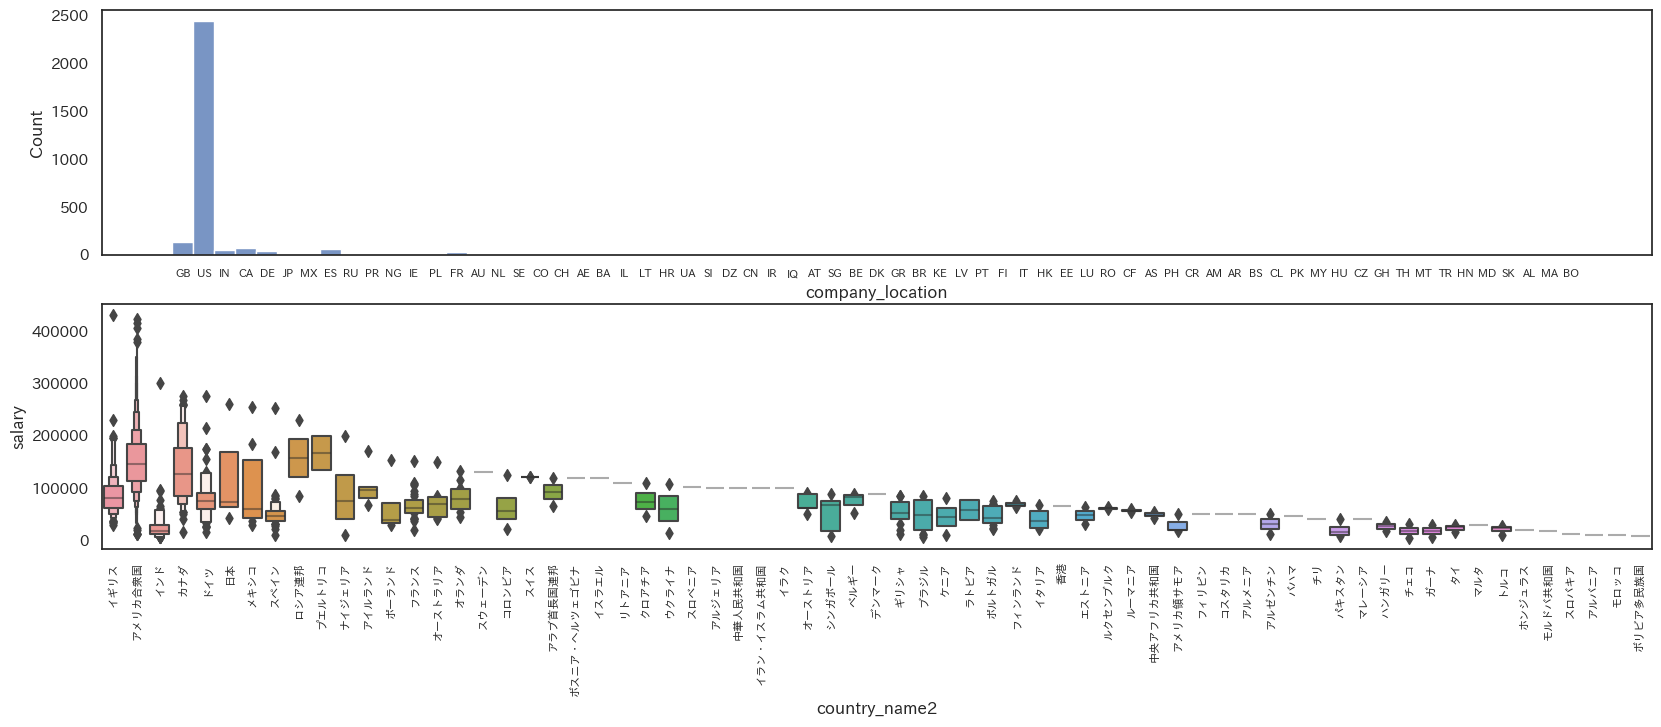

In [12]:
# 1-8 company_location

df['country_name2'] = df['company_location'].apply(lambda x: ISO_dict[x])
display(df)
print(set(df_test['company_location'])-set(df['company_location']))

df01 = df.sort_values('salary', ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(x=df01['company_location'], ax=ax1)
sns.boxenplot(df01, x='country_name2', y='salary', ax=ax2)
ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='x', rotation=90, labelsize=8)

display(df[df['country_name']!=df['country_name2']].describe())
display(df[df['country_name']=='ロシア連邦'])

# 分布はほとんどemployee_residenceと同じ。ロシアの給与水準が違って見えるのはロシア国内に1名高給のscientistがいるから
# company_locationとemployee_residenceが異なる層が76名いるが基本的に低給与なのでこの点のみ使えるか。
# なお、df_testにのみ存在するcompany_locationが5つある。'NZ', 'VN', 'ID', 'EG', 'MK'


salary            
              count        mean
company_size                   
M              2526  143400.703
L               358  117745.693
S               120   78492.775

<Axes: xlabel='company_size', ylabel='salary'>

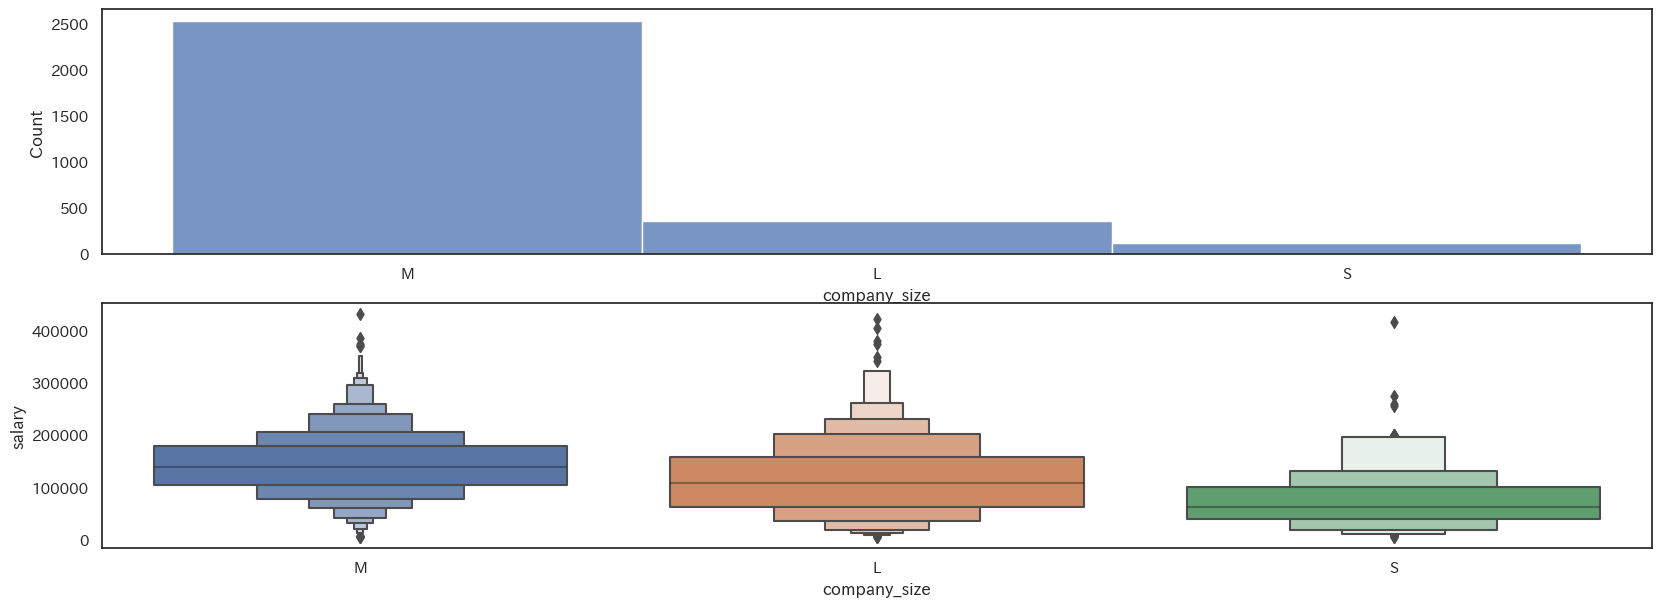

In [13]:
# 1-9 company_size

df_ = df.groupby(['company_size'])[['salary']].agg(['count', 'mean']).sort_values(('salary', 'mean'), ascending=False)
display(df_)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(df.company_size, ax=ax1)
sns.boxenplot(x='company_size',y='salary', data=df, ax=ax2)

# 会社の規模はSだと傾向として低給与だが、MがLより高水準
# 数もMが大部分を占める


## 前処理、特徴量エンジニアリング

### (1)欠損値処理

In [14]:
# 2-1 欠損値処理

# 欠損値                     ： train
# employment_type            :    12
# remote_ratio               :  1518

# employment_type
df['employment_type'] = df['employment_type'].fillna('FL')

# remote_ratio
df['remote_ratio'] = df['remote_ratio'].fillna(float(100))

display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               3004 non-null   int64  
 1   work_year           3004 non-null   int64  
 2   experience_level    3004 non-null   object 
 3   employment_type     3004 non-null   object 
 4   job_title           3004 non-null   object 
 5   employee_residence  3004 non-null   object 
 6   remote_ratio        3004 non-null   float64
 7   company_location    3004 non-null   object 
 8   company_size        3004 non-null   object 
 9   salary              3004 non-null   int64  
 10  position            3004 non-null   object 
 11  job                 3004 non-null   object 
 12  country_name        3004 non-null   object 
 13  country_name2       3004 non-null   object 
dtypes: float64(1), int64(3), object(10)
memory usage: 328.7+ KB


None

In [15]:
# 2-2 外れ値処理
# MIの2名とENの１名は削除する
display(df[(df['experience_level']=='MI') & (df['salary'] >= 400000)])
display(df[(df['experience_level']=='EN') & (df['salary'] >= 300000)])
df = df.drop(index=[2252, 2591, 2911])
display(df[(df['experience_level']=='MI') & (df['salary'] >= 400000)])
display(df[(df['experience_level']=='EN') & (df['salary'] >= 300000)])


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job,country_name,country_name2
2252,2011,2022,MI,FT,Data Analyst,GB,0.0,GB,M,430967,Non_title,Analyst,イギリス,イギリス
2591,3747,2021,MI,FT,Applied Machine Learning Scientist,US,50.0,US,L,423000,Non_title,Scientist,アメリカ合衆国,アメリカ合衆国


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job,country_name,country_name2
2911,83,2022,EN,FT,AI Developer,IN,50.0,IN,L,300000,Non_title,Developer,インド,インド


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job,country_name,country_name2


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job,country_name,country_name2


### （2）特徴量生成

In [16]:
# 3-1, 3-2 job: EDAで作成したjob, positionはそのまま特徴量として使用

# 3-3 living_abroad
df['living_abroad'] = df.apply(lambda x: 1 if x['company_location'] == x['employee_residence'] else 0, axis=1)

# employee_residenceとcompany_locationは差分が低所得なので抽出して特徴量にする


In [17]:
# 3-4 ex_position
df['ex_position'] = df.apply(lambda x: x['position'] + x['experience_level'], axis=1)

# experience_levelをpositionと組み合わせて特徴量にする

In [18]:
# 3-5 North_America
df['North_America'] = df.apply(lambda x: 1 if x['company_location'] in ['US', 'CA', 'PR'] else 0, axis=1)

# 北米（米国、カナダ、プエルトリコ）かそれ以外

### （3）質的変数のエンコーディング

In [19]:
# 4-0 バリデーションデータの分割

df_train, df_val = train_test_split(df, test_size=0.2)

In [20]:
# 4-1 ターゲットエンコーディング

# work_yearは2023年水準（1）に対する比率で表現、他は質的変数を要素カテゴリの中央値で置き換える
# 置き換え後の数値はカテゴリ中の最大値で割って最大値1.0に収める（別途標準化は行わない）
# なお、置き換え辞書はdf_trainで作成し、目的変数のリークを防止
# experience_level, employment_type, job_title, employee_residence,
# remote_ratio, company_location,company_size, job, ex_job, position, ex_position

max_salary = max(df_train['salary'])

# work_year
y2020 = df_train[df_train['work_year']==2020]['salary'].mean()
y2021 = df_train[df_train['work_year']==2021]['salary'].mean()
y2022 = df_train[df_train['work_year']==2022]['salary'].mean()
y2023 = df_train[df_train['work_year']==2023]['salary'].mean()

dic_WY = {2023: 1, 2022: y2022/y2023, 2021: y2021/y2023, 2020: y2020/y2023}
df_train['work_year'] = df_train['work_year'].map(dic_WY)
df_val['work_year'] = df_val['work_year'].map(dic_WY)
#tmp = df_train.groupby('work_year')['salary'].mean()
#dic_WY = (tmp / max_salary).to_dict()
#df_train['work_year'] = df_train['work_year'].map(dic_WY)
#df_val['work_year'] = df_val['work_year'].map(dic_WY)

tmp = df_train.groupby('experience_level')['salary'].mean()
dic_EL = (tmp / max_salary).to_dict()
df_train['experience_level'] = df_train['experience_level'].map(dic_EL)
df_val['experience_level'] = df_val['experience_level'].map(dic_EL)

tmp = df_train.groupby('employment_type')['salary'].mean()
dic_ET = (tmp / max_salary).to_dict()
df_train['employment_type'] = df_train['employment_type'].map(dic_ET)
df_val['employment_type'] = df_val['employment_type'].map(dic_ET)

tmp = df_train.groupby('job_title')['salary'].mean()
dic_JT = (tmp / max_salary).to_dict()
# df_trainに含まれない要素は全体の平均値とする
dif_val = set(df_val['job_title'])-set(df_train['job_title'])
for i in dif_val:
    dic_JT[i] = df_train['salary'].mean()/df_train['salary'].max()
df_train['job_title'] = df_train['job_title'].map(dic_JT)
df_val['job_title'] = df_val['job_title'].map(dic_JT)

tmp = df_train.groupby('employee_residence')['salary'].mean()
dic_ER = (tmp / max_salary).to_dict()
# df_trainに含まれない要素は全体の平均値とする
dif_val = set(df_val['employee_residence'])-set(df_train['employee_residence'])
for i in dif_val:
    dic_ER[i] = df_train['salary'].mean()/df_train['salary'].max()
df_train['employee_residence'] = df_train['employee_residence'].map(dic_ER)
df_val['employee_residence'] = df_val['employee_residence'].map(dic_ER)

tmp = df_train.groupby('remote_ratio')['salary'].mean()
dic_RR = (tmp / max_salary).to_dict()
df_train['remote_ratio'] = df_train['remote_ratio'].map(dic_RR)
df_val['remote_ratio'] = df_val['remote_ratio'].map(dic_RR)

tmp = df_train.groupby('company_location')['salary'].mean()
dic_CL = (tmp / max_salary).to_dict()
# df_trainに含まれない要素は全体の平均値とする
dif_val = set(df_val['company_location'])-set(df_train['company_location'])
for i in dif_val:
    dic_CL[i] = df_train['salary'].mean()/df_train['salary'].max()
df_train['company_location'] = df_train['company_location'].map(dic_CL)
df_val['company_location'] = df_val['company_location'].map(dic_CL)

tmp = df_train.groupby('company_size')['salary'].mean()
dic_CS = (tmp / max_salary).to_dict()
df_train['company_size'] = df_train['company_size'].map(dic_CS)
df_val['company_size'] = df_val['company_size'].map(dic_CS)

tmp = df_train.groupby('job')['salary'].mean()
dic_job = (tmp / max_salary).to_dict()
dif_val = set(df_val['job'])-set(df_train['job'])
for i in dif_val:
    dic_job[i] = df_train['salary'].mean()/df_train['salary'].max()
df_train['job'] = df_train['job'].map(dic_job)
df_val['job'] = df_val['job'].map(dic_job)

tmp = df_train.groupby('position')['salary'].mean()
dic_PO = (tmp / max_salary).to_dict()
# df_trainに含まれない要素は全体の平均値とする
dif_val = set(df_val['position'])-set(df_train['position'])
for i in dif_val:
    dic_PO[i] = df_train['salary'].mean()/df_train['salary'].max()
df_train['position'] = df_train['position'].map(dic_PO)
df_val['position'] = df_val['position'].map(dic_PO)

tmp = df_train.groupby('ex_position')['salary'].mean()
dic_EP = (tmp / max_salary).to_dict()
# df_trainに含まれない要素は全体の平均値とする
dif_val = set(df_val['ex_position'])-set(df_train['ex_position'])
for i in dif_val:
    dic_EP[i] = df_train['salary'].mean()/df_train['salary'].max()
df_train['ex_position'] = df_train['ex_position'].map(dic_EP)
df_val['ex_position'] = df_val['ex_position'].map(dic_EP)


In [21]:
# 2-4 特徴量削除
# indexのほか、EDAで使用した国名の読み替え列は削除
# company_location、employee_residence、'job_title'は集約、整理したので削除
# position, experience_levelを削除してex_positionを採用

df_train = df_train.drop(columns=['index', 'company_location', 'country_name', 'country_name2', 'employee_residence', 'job_title', 'position', 'experience_level'])
df_val = df_val.drop(columns=['index', 'company_location', 'country_name', 'country_name2', 'employee_residence', 'job_title', 'position', 'experience_level'])

display(df_train)
display(df_train.describe())

,work_year,employment_type,remote_ratio,company_size,salary,job,living_abroad,ex_position,North_America
2819,0.893,0.331,0.326,0.344,73546,0.349,1,0.365,0
1949,0.893,0.331,0.326,0.344,243000,0.349,1,0.365,1
2470,0.893,0.331,0.347,0.344,102100,0.349,1,0.365,1
2914,0.893,0.331,0.326,0.344,78000,0.349,1,0.243,0
2408,0.610,0.331,0.347,0.276,100000,0.343,0,0.192,0
...,...,...,...,...,...,...,...,...,...
417,0.610,0.331,0.326,0.182,80000,0.248,0,0.365,1
1073,0.893,0.331,0.326,0.276,83864,0.349,1,0.243,0
1912,0.496,0.331,0.326,0.182,76958,0.343,1,0.243,0
1357,1.000,0.331,0.326,0.344,107250,0.349,1,0.365,1


,work_year,employment_type,remote_ratio,company_size,salary,job,living_abroad,ex_position,North_America
count,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000
mean,0.920,0.329,0.329,0.329,136953.772,0.329,0.977,0.329,0.835
std,0.111,0.017,0.036,0.037,62685.658,0.042,0.151,0.070,0.371
min,0.496,0.115,0.178,0.182,5132.000,0.110,0.000,0.111,0.000
25%,0.893,0.331,0.326,0.344,94000.000,0.343,1.000,0.243,1.000
50%,0.893,0.331,0.347,0.344,135000.000,0.349,1.000,0.365,1.000
75%,1.000,0.331,0.347,0.344,175000.000,0.349,1.000,0.365,1.000
max,1.000,0.331,0.347,0.344,416000.000,0.395,1.000,1.000,1.000


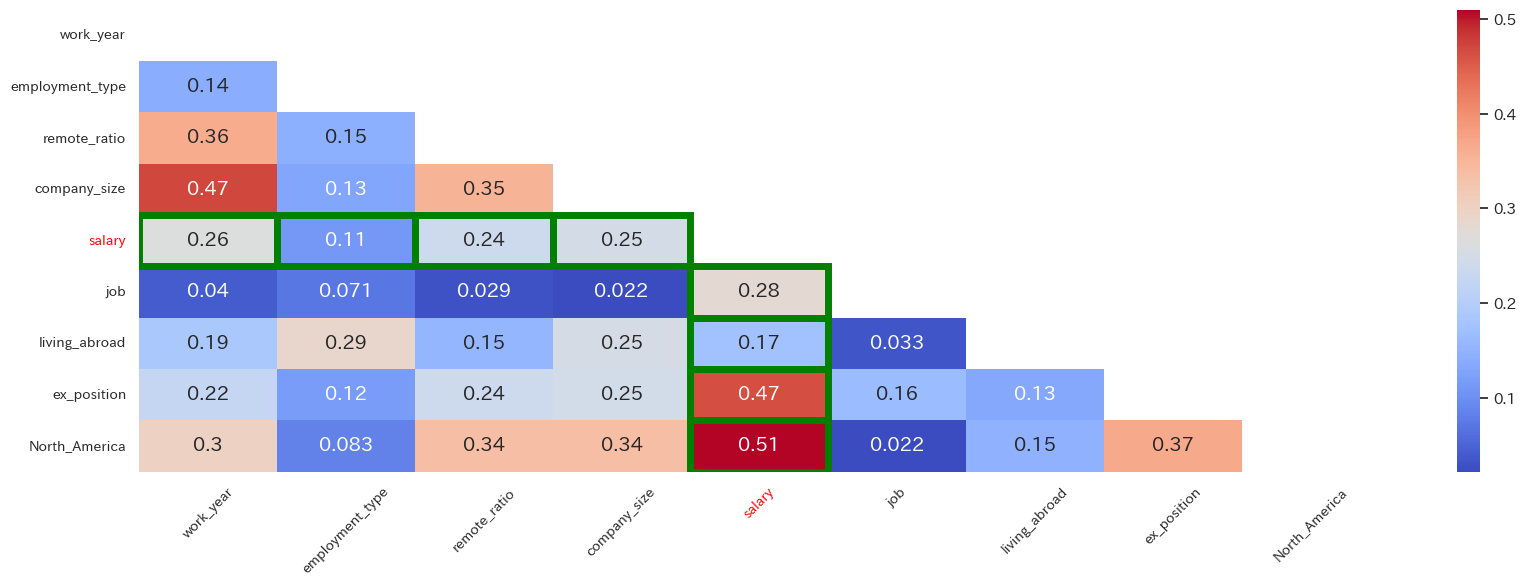

In [22]:
# ヒートマップ,相関係数
corr = df_train.corr()
fig, ax = plt.subplots(figsize=(20, 6))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={'size':14})
ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=10)

# 目的変数の枠線の追加
index = list(corr.columns).index('salary')
for i in range(len(corr.columns)):
    if i > index:
        plt.gca().add_patch(plt.Rectangle((index, i), 1, 1,
                                          fill=False, edgecolor='green', lw=5))
    elif i < index:
        plt.gca().add_patch(plt.Rectangle((i, index), 1, 1,
                                          fill=False, edgecolor='green', lw=5))

# 目的変数の強調
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == 'salary':
        label.set_color('red')
        label.set_fontweight('bold')
for i, label in enumerate(ax.get_yticklabels()):
    if label.get_text() == 'salary':
        label.set_color('red')
        label.set_fontweight('bold')
plt.show()

### バリデーション

In [23]:
#3-1
# 6-1 説明変数と目的変数のセット

X_train = df_train.drop('salary', axis=1)
y_train = df_train.salary
X_test = df_val.drop('salary', axis=1)
y_test = df_val.salary

# 6-2 各モデルのインスタンス化

linear_model = LinearRegression()
ridge_model = Ridge(alpha=10)
lasso_model = Lasso(alpha=0.3)
tree_model = tree.DecisionTreeRegressor(max_leaf_nodes = 20)
RFG_model = RandomForestRegressor()

# 6-3 トレーニングの実施

linear_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
RFG_model.fit(X_train, y_train)

# 6-4 モデルの係数表示（Linear_model）
coef = pd.DataFrame(data=[linear_model.coef_, ridge_model.coef_, lasso_model.coef_],
                    index=['Linear Regression coefficients',
                           'Ridge Regression coefficients',
                           'LASSO Regression coefficients'], columns=X_train.columns)
display(coef.T)

# 6-5 テストデータの予測

linear_pred = linear_model.predict(X_test)
ridge_pred = ridge_model.predict(X_test)
lasso_pred = lasso_model.predict(X_test)
tree_pred = tree_model.predict(X_test)
RFG_pred = RFG_model.predict(X_test)

# 6-6 RMES(二乗平均平方根誤差)の計算

linear_RMES = np.sqrt(mean_squared_error(y_test, linear_pred))
ridge_RMES = np.sqrt(mean_squared_error(y_test, ridge_pred))
lasso_RMES = np.sqrt(mean_squared_error(y_test, lasso_pred))
tree_RMES = np.sqrt(mean_squared_error(y_test, tree_pred))
RFG_RMES = np.sqrt(mean_squared_error(y_test, tree_pred))

#  6-7 RMESを表示

print(f'RMES for Linear Regression:{linear_RMES:.2f}')
print(f'RMES for Ridge Regression:{ridge_RMES:.2f}')
print(f'RMES for LASSO Regression:{lasso_RMES:.2f}')
print(f'RMES for Tree Regression:{tree_RMES:.2f}')
print(f'RMES for RFG Regression:{RFG_RMES:.2f}')

# 6-8 R^2（決定係数）スコアの計算

linear_r2 = r2_score(y_test, linear_pred)
ridge_r2 = r2_score(y_test, ridge_pred)
lasso_r2 = r2_score(y_test, lasso_pred)
tree_r2 = r2_score(y_test, tree_pred)
RFG_r2 = r2_score(y_test, RFG_pred)

# 6-9 R^2スコアを比較

print(f'R^2 score for Linear Regression:{linear_r2:.2f}')
print(f'R^2 score for Ridge Regression:{ridge_r2:.2f}')
print(f'R^2 score for LASSO Regression:{lasso_r2:.2f}')
print(f'R^2 score for Tree Regression:{tree_r2:.2f}')
print(f'R^2 score for RFG Regression:{RFG_r2:.2f}')


,Linear Regression coefficients,Ridge Regression coefficients,LASSO Regression coefficients
work_year,38702.236,37224.366,38738.486
employment_type,21525.099,6037.408,20466.558
remote_ratio,9551.073,10579.891,9375.453
company_size,1503.955,9354.149,1299.902
job,330866.557,107668.347,330730.550
living_abroad,24785.174,26624.623,24818.350
ex_position,237232.038,134532.934,237219.212
North_America,63382.638,68796.360,63393.133


RMES for Linear Regression:46241.52
RMES for Ridge Regression:47834.43
RMES for LASSO Regression:46241.39
RMES for Tree Regression:46871.52
RMES for RFG Regression:46871.52
R^2 score for Linear Regression:0.40
R^2 score for Ridge Regression:0.36
R^2 score for LASSO Regression:0.40
R^2 score for Tree Regression:0.38
R^2 score for RFG Regression:0.41


In [24]:
# Light GBM
import lightgbm as lgb

params = {"objective": "regression","metrics": "rmse"}
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(params, trains, valid_sets=valids,
                      num_boost_round=500, early_stopping_rounds=100)
lgb_pred = lgb_model.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 8
[LightGBM] [Info] Start training from score 136953.771667
[1]	valid_0's rmse: 57259.4
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 55161.5
[3]	valid_0's rmse: 53417.1
[4]	valid_0's rmse: 51965.9
[5]	valid_0's rmse: 50730.7
[6]	valid_0's rmse: 49756.3
[7]	valid_0's rmse: 48960.8
[8]	valid_0's rmse: 48332.6
[9]	valid_0's rmse: 47739.4
[10]	valid_0's rmse: 47257.2
[11]	valid_0's rmse: 46899.2
[12]	valid_0's rmse: 46632.5
[13]	valid_0's rmse: 46385.3
[14]	valid_0's rmse: 46201.9
[15]	valid_0's rmse: 46053.7
[16]	valid_0's rmse: 45936.4
[17]	valid_0's rmse: 45871
[18]	valid_0's rmse: 45797.4
[19]	valid_0's rm

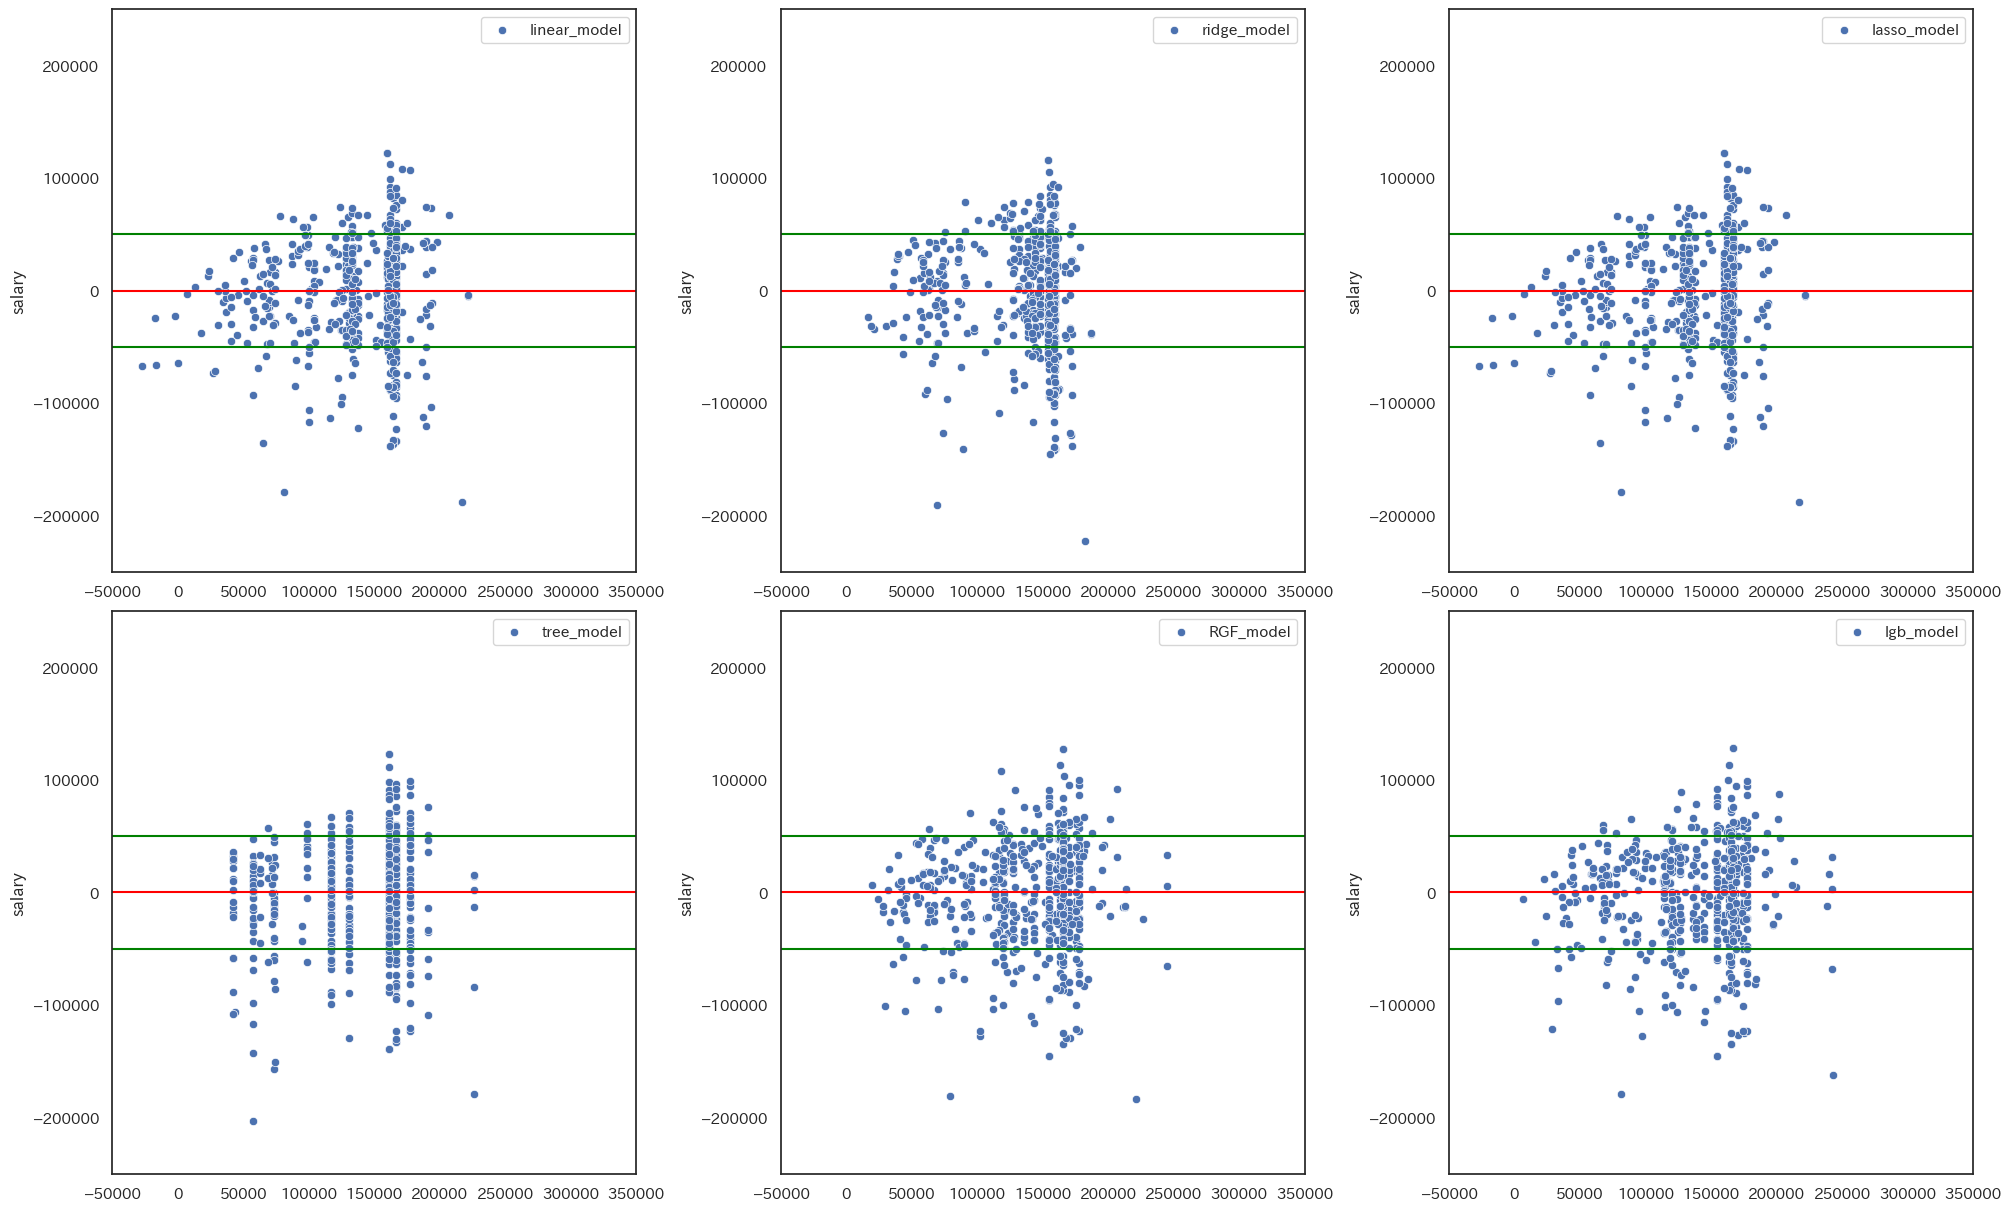

In [25]:
# 可視化(残差グラフ)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20,12), layout='constrained')
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
labels = ['linear_model', 'ridge_model', 'lasso_model', 'tree_model', 'RGF_model', 'lgb_model']
preds = [linear_pred, ridge_pred, lasso_pred, tree_pred, RFG_pred, lgb_pred]

for ax, l, p in zip(axs, labels, preds):
    sns.scatterplot(x=p, y=(p-y_test), ax=ax, label=l)
    ax.hlines(50000, -50000, 350000, color='green')
    ax.hlines(-50000, -50000, 350000, color='green')
    ax.hlines(0, -50000, 350000, color='red')
    ax.set_xlim(-50000, 350000)
    ax.set_ylim(-250000, 250000)
    ax.legend()


## 提出用データ

In [26]:
# df全体で改めて予測
# ターゲットエンコーディングをしているので、dfの読み込み以降のEDAを除く全てのプロセスを再度実施する必要がある

In [27]:
# 0-2
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\datascientist_salary\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\datascientist_salary\\test.csv') 

In [28]:
# EDAで作成した特徴量jobの再生（国名の読み替えは使用しないので作成しない）

for i, j in enumerate(df['job_title']):
    if j.split()[0] == 'Head':
        df.at[i, 'position'] = 'Head'
        df.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Director':
        df.at[i, 'position'] = 'Director'
        df.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Principal':
        df.at[i, 'position'] = 'Principal'
        df.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[-1] in ['Lead', 'Manager', 'Management']:
        df.at[i, 'position'] = j.split()[-1]
        df.at[i, 'job'] = j.split()[-1]
    else:
        df.at[i, 'position'] = 'Non_title'
        df.at[i, 'job'] = j.split()[-1]

for i, j in enumerate(df_test['job_title']):
    if j.split()[0] == 'Head':
        df_test.at[i, 'position'] = 'Head'
        df_test.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Director':
        df_test.at[i, 'position'] = 'Director'
        df_test.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[0] == 'Principal':
        df_test.at[i, 'position'] = 'Principal'
        df_test.at[i, 'job'] = 'Head' if j.split()[-1] in ['Data', 'Science'] else j.split()[-1]
    elif j.split()[-1] in ['Lead', 'Manager', 'Management']:
        df_test.at[i, 'position'] = j.split()[-1]
        df_test.at[i, 'job'] = j.split()[-1]
    else:
        df_test.at[i, 'position'] = 'Non_title'
        df_test.at[i, 'job'] = j.split()[-1]


In [29]:
# 2-1 欠損値処理

# 欠損値                     ： train   test
# employment_type            :   12       5
# remote_ratio               : 1518     405

# employment_type
df['employment_type'] = df['employment_type'].fillna('FL')
df_test['employment_type'] = df_test['employment_type'].fillna('FL')

# remote_ratio
df['remote_ratio'] = df['remote_ratio'].fillna(float(100))
df_test['remote_ratio'] = df_test['remote_ratio'].fillna(float(100))

display(df.info())
display(df_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               3004 non-null   int64  
 1   work_year           3004 non-null   int64  
 2   experience_level    3004 non-null   object 
 3   employment_type     3004 non-null   object 
 4   job_title           3004 non-null   object 
 5   employee_residence  3004 non-null   object 
 6   remote_ratio        3004 non-null   float64
 7   company_location    3004 non-null   object 
 8   company_size        3004 non-null   object 
 9   salary              3004 non-null   int64  
 10  position            3004 non-null   object 
 11  job                 3004 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 281.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               751 non-null    int64  
 1   work_year           751 non-null    int64  
 2   experience_level    751 non-null    object 
 3   employment_type     751 non-null    object 
 4   job_title           751 non-null    object 
 5   employee_residence  751 non-null    object 
 6   remote_ratio        751 non-null    float64
 7   company_location    751 non-null    object 
 8   company_size        751 non-null    object 
 9   position            751 non-null    object 
 10  job                 751 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 64.7+ KB


None

In [30]:
# 2-2 外れ値処理
# MIの2名とENの１名は削除する
display(df[(df['experience_level']=='MI') & (df['salary'] >= 300000)])
display(df[(df['experience_level']=='EN') & (df['salary'] >= 300000)])
df = df.drop(index=[2252, 2591, 2911])
display(df[(df['experience_level']=='MI') & (df['salary'] >= 300000)])
display(df[(df['experience_level']=='EN') & (df['salary'] >= 300000)])


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job
143,190,2023,MI,FT,Machine Learning Engineer,US,100.0,US,M,300000,Non_title,Engineer
2252,2011,2022,MI,FT,Data Analyst,GB,100.0,GB,M,430967,Non_title,Analyst
2591,3747,2021,MI,FT,Applied Machine Learning Scientist,US,50.0,US,L,423000,Non_title,Scientist


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job
2911,83,2022,EN,FT,AI Developer,IN,50.0,IN,L,300000,Non_title,Developer


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job
143,190,2023,MI,FT,Machine Learning Engineer,US,100.0,US,M,300000,Non_title,Engineer


,index,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary,position,job


In [31]:
# 3-1, 3-2 job: EDAで作成したjobとpositionはそのまま特徴量として使用

# 3-3 living_abroad
df['living_abroad'] = df.apply(lambda x: 1 if x['company_location'] == x['employee_residence'] else 0, axis=1)
df_test['living_abroad'] = df_test.apply(lambda x: 1 if x['company_location'] == x['employee_residence'] else 0, axis=1)

# employee_residenceとcompany_locationがほぼほぼ重なっているので差分を抽出して特徴量とするもの


In [32]:
# 3-4 ex_position
df['ex_position'] = df.apply(lambda x: x['position'] + x['experience_level'], axis=1)
df_test['ex_position'] = df_test.apply(lambda x: x['position'] + x['experience_level'], axis=1)

# experience_levelとpositionを組み合わる

In [33]:
# 3-5 North_America
df['North_America'] = df.apply(lambda x: 1 if x['company_location'] in ['US', 'CA', 'PR'] else 0, axis=1)
df_test['North_America'] = df_test.apply(lambda x: 1 if x['company_location'] in ['US', 'CA', 'PR'] else 0, axis=1)

# 北米（米国、カナダ、プエルトリコ）かそれ以外

In [34]:

# ターゲットエンコーディング
# work_year, experience_level, employment_type, job_title, employee_residence,
# remote_ratio, company_location, company_size, job, position, ex_position

max_salary = df['salary'].max()

y2020 = df[df['work_year']==2020]['salary'].mean()
y2021 = df[df['work_year']==2021]['salary'].mean()
y2022 = df[df['work_year']==2022]['salary'].mean()
y2023 = df[df['work_year']==2023]['salary'].mean()
dic_WY = {2023: 1, 2022: y2022/y2023, 2021: y2021/y2023, 2020: y2020/y2023}
df['work_year'] = df['work_year'].map(dic_WY)
df_test['work_year'] = df_test['work_year'].map(dic_WY)

#tmp = df.groupby('work_year')['salary'].mean()
#dic_WY = (tmp / max_salary).to_dict()
#df['work_year'] = df['work_year'].map(dic_WY)
#df_test['work_year'] = df_test['work_year'].map(dic_WY)

tmp = df.groupby('experience_level')['salary'].mean()
dic_EL = (tmp / max_salary).to_dict()
df['experience_level'] = df['experience_level'].map(dic_EL)
df_test['experience_level'] = df_test['experience_level'].map(dic_EL)

tmp = df.groupby('employment_type')['salary'].mean()
dic_ET = (tmp / max_salary).to_dict()
df['employment_type'] = df['employment_type'].map(dic_ET)
df_test['employment_type'] = df_test['employment_type'].map(dic_ET)

tmp = df.groupby('job_title')['salary'].mean()
dic_JT = (tmp / max_salary).to_dict()
dif_test = set(df_test['job_title'])-set(df['job_title'])
for i in dif_test:
    dic_JT[i] = df['salary'].mean() / df['salary'].max()
df['job_title'] = df['job_title'].map(dic_JT)
df_test['job_title'] = df_test['job_title'].map(dic_JT)

tmp = df.groupby('employee_residence')['salary'].mean()
dic_ER = (tmp / max_salary).to_dict()
dif_test = set(df_test['employee_residence'])-set(df['employee_residence'])
for i in dif_test:
    dic_ER[i] = df['salary'].mean() / df['salary'].max()
df['employee_residence'] = df['employee_residence'].map(dic_ER)
df_test['employee_residence'] = df_test['employee_residence'].map(dic_ER)

tmp = df.groupby('remote_ratio')['salary'].mean()
dic_RR = (tmp / max_salary).to_dict()
df['remote_ratio'] = df['remote_ratio'].map(dic_RR)
df_test['remote_ratio'] = df_test['remote_ratio'].map(dic_RR)

tmp = df.groupby('company_location')['salary'].mean()
dic_CL = (tmp / max_salary).to_dict()
dif_test = set(df_test['company_location'])-set(df['company_location'])
for i in dif_test:
    dic_CL[i] = df['salary'].mean() / df['salary'].max()
df['company_location'] = df['company_location'].map(dic_CL)
df_test['company_location'] = df_test['company_location'].map(dic_CL)

tmp = df.groupby('company_size')['salary'].mean()
dic_CS = (tmp / max_salary).to_dict()
df['company_size'] = df['company_size'].map(dic_CS)
df_test['company_size'] = df_test['company_size'].map(dic_CS)

tmp = df.groupby('job')['salary'].mean()
dic_job = (tmp / max_salary).to_dict()
df['job'] = df['job'].map(dic_job)
df_test['job'] = df_test['job'].map(dic_job)

tmp = df.groupby('position')['salary'].mean()
dic_PO = (tmp / max_salary).to_dict()
df['position'] = df['position'].map(dic_PO)
df_test['position'] = df_test['position'].map(dic_PO)

tmp = df.groupby('ex_position')['salary'].mean()
dic_EP = (tmp / max_salary).to_dict()
# df_trainに含まれない要素は全体の平均値とする
dif_test = set(df_test['ex_position'])-set(df['ex_position'])
for i in dif_val:
    dic_EP[i] = df['salary'].mean()/df['salary'].max()
df['ex_position'] = df['ex_position'].map(dic_EP)
df_test['ex_position'] = df_test['ex_position'].map(dic_EP)


In [36]:
# 特徴量削除
df = df.drop(columns=['index', 'company_location', 'employee_residence', 'job_title', 'position', 'experience_level'])
df_test = df_test.drop(columns=['index', 'company_location', 'employee_residence', 'job_title', 'position', 'experience_level'])


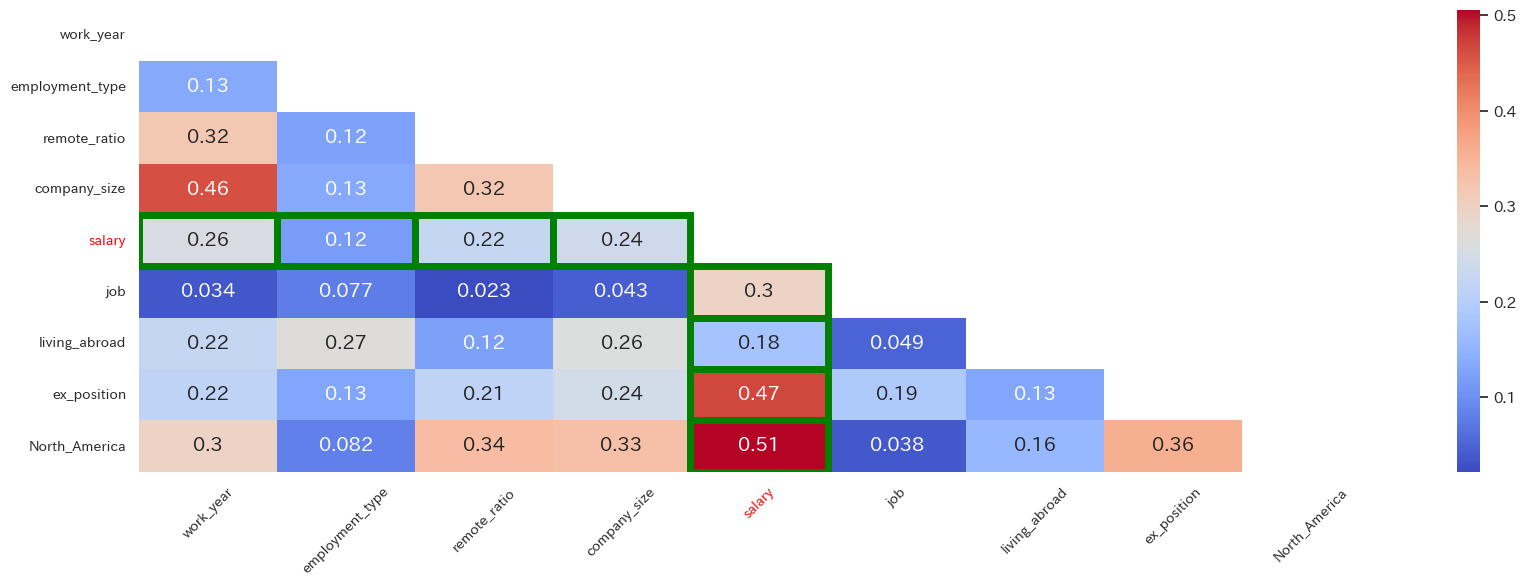

In [37]:
# ヒートマップ,相関係数
corr = df.corr()
fig, ax = plt.subplots(figsize=(20, 6))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={'size':14})
ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=10)

# 目的変数の枠線の追加
index = list(corr.columns).index('salary')
for i in range(len(corr.columns)):
    if i > index:
        plt.gca().add_patch(plt.Rectangle((index, i), 1, 1,
                                          fill=False, edgecolor='green', lw=5))
    elif i < index:
        plt.gca().add_patch(plt.Rectangle((i, index), 1, 1,
                                          fill=False, edgecolor='green', lw=5))

# 目的変数の強調
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == 'salary':
        label.set_color('red')
        label.set_fontweight('bold')
for i, label in enumerate(ax.get_yticklabels()):
    if label.get_text() == 'salary':
        label.set_color('red')
        label.set_fontweight('bold')
plt.show()

In [38]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   work_year        751 non-null    float64
 1   employment_type  751 non-null    float64
 2   remote_ratio     751 non-null    float64
 3   company_size     751 non-null    float64
 4   job              751 non-null    float64
 5   living_abroad    751 non-null    int64  
 6   ex_position      751 non-null    float64
 7   North_America    751 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 47.1 KB


In [40]:

X = df.drop('salary', axis=1)
y = df.salary

# 6-2 各モデルのインスタンス化

linear_model = LinearRegression()
ridge_model = Ridge(alpha=5)
lasso_model = Lasso(alpha=0.03)
tree_model = tree.DecisionTreeRegressor(max_leaf_nodes = 20)
RFG_model = RandomForestRegressor()

# 6-3 トレーニングの実施

linear_model.fit(X, y)
ridge_model.fit(X, y)
lasso_model.fit(X, y)
tree_model.fit(X, y)
RFG_model.fit(X, y)

# 6-4 モデルの係数表示（Linear_model）
coef = pd.DataFrame(data=[linear_model.coef_, ridge_model.coef_, lasso_model.coef_],
                    index=['Linear Regression coefficients',
                           'Ridge Regression coefficients',
                           'LASSO Regression coefficients'], columns=X.columns)
display(coef.T)

# 6-5 テストデータの予測

linear_pred = linear_model.predict(df_test)
ridge_pred = ridge_model.predict(df_test)
lasso_pred = lasso_model.predict(df_test)
tree_pred = tree_model.predict(df_test)
RFG_pred = RFG_model.predict(df_test)


,Linear Regression coefficients,Ridge Regression coefficients,LASSO Regression coefficients
work_year,40257.474,38110.339,40253.423
employment_type,31908.584,11260.823,31808.409
remote_ratio,18992.211,12254.830,18961.164
company_size,-18449.085,3427.975,-18403.559
job,316803.995,179155.529,316791.805
living_abroad,22382.489,24371.405,22383.208
ex_position,238720.867,184843.923,238717.455
North_America,62343.768,65433.142,62344.001


In [41]:
# Light GBM

params = {"objective": "regression","metrics": "rmse"}
trains = lgb.Dataset(X, y)
lgb_model = lgb.train(params, trains, num_boost_round=1000)
lgb_pred = lgb_model.predict(df_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 3001, number of used features: 8
[LightGBM] [Info] Start training from score 137503.599134


In [42]:
# 7-2 提出用データファイルのセッティング
df_submit = pd.read_csv('C:\\Users\\yuich\\KC_data\\datascientist_salary\\sample_submission.csv')
df_submit['y'] = linear_pred
df_submit.set_index('index', inplace=True)
df_submit.to_csv('submission.csv')